In [26]:
!pip install skforecast
!pip install statsmodels

In [27]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [28]:
water_consumptions = pd.read_csv('./data/water_consumptions_100.csv')
print(water_consumptions.dtypes)
water_consumptions.head()

id              int64
datetime       object
consumption     int64
dtype: object


,id,datetime,consumption
0,0,2019-02-01,243
1,0,2019-02-02,236
2,0,2019-02-03,335
3,0,2019-02-04,252
4,0,2019-02-05,220


In [29]:
water_consumptions['datetime'] = water_consumptions['datetime'].apply(pd.to_datetime)
water_consumptions.dtypes

id                      int64
datetime       datetime64[ns]
consumption             int64
dtype: object

## Data preparation



In [30]:
N_DAYS_YEAR = 365

id_length = water_consumptions.groupby(['id']).size()
print('Number of series:', len(id_length))
complete_series_ids = id_length[id_length == N_DAYS_YEAR]
complete_series_ids = complete_series_ids.to_frame().reset_index()
print('Number of complete series: ', len(complete_series_ids))

Number of series: 101
Number of complete series:  81


In [31]:
complete_series_df = water_consumptions[water_consumptions['id'].isin(complete_series_ids['id'])]
complete_series_df

,id,datetime,consumption
0,0,2019-02-01,243
1,0,2019-02-02,236
2,0,2019-02-03,335
3,0,2019-02-04,252
4,0,2019-02-05,220
...,...,...,...
35589,100,2020-01-27,471
35590,100,2020-01-28,445
35591,100,2020-01-29,720
35592,100,2020-01-30,402


In [32]:
consumption_series = dict()

for id in set(complete_series_df['id']):
  id_df = complete_series_df[complete_series_df['id'] == id]
  date_consumption_df = id_df.loc[:,["datetime","consumption"]]
  date_consumption_df.set_index("datetime",inplace=True)
  date_consumption_df.sort_index(inplace=True)
  consumption_series[id] = date_consumption_df


### Standarization
Once we have the train-test datasets, it's the time to prepare them to improve the performance of the models. In order to do that, we standarize the time series to make the easier to use for the algorithms.
In most cases, it is very important to take care that there is no information leakage between testing and training data. But, in this case, as we want to replicate the clutering from the EDA. We will do, first a complete-dataset-normalization and for train-test we will fit on the training data and then apply the same to the test data

In [33]:
from sklearn.preprocessing import StandardScaler

for index in consumption_series:
    scaler = StandardScaler()
    consumption_series[index] = scaler.fit_transform(consumption_series[index])
    consumption_series[index] = consumption_series[index].reshape(len(consumption_series[index]))
    
water_series_anonimized = list(consumption_series.values())
water_series_anonimized[0]

array([-3.72417048e-01, -4.37922043e-01,  4.88505743e-01, -2.88196340e-01,
       -5.87647745e-01, -6.36077857e-02, -5.42499293e-02, -8.40309869e-01,
       -1.94617776e-01,  3.01348615e-01, -5.50216320e-01,  5.07221456e-01,
       -5.97005602e-01, -1.75902063e-01,  9.47040708e-01, -3.55342164e-02,
        5.63368595e-01,  3.48137897e-01,  1.19034498e+00, -2.22691345e-01,
        2.82632902e-01,  9.18967139e-01, -5.68932033e-01,  6.75662872e-01,
        9.37682852e-01, -3.25627766e-01,  2.91990758e-01, -9.61962002e-01,
       -6.99942023e-01, -4.94069181e-01,  6.66305015e-01,  3.57495753e-01,
        3.38780040e-01,  1.89054338e-01, -3.72417048e-01, -1.38306554e+00,
       -1.57186350e-01,  1.31199711e+00,  2.45365559e+00, -5.87647745e-01,
       -6.90584166e-01,  1.80796350e+00,  3.85569323e-01,  2.99707785e-02,
       -5.40858463e-01, -6.43794884e-01,  1.15291355e+00,  1.12550657e-02,
        9.09609282e-01, -8.77741295e-01,  9.54757735e-02,  9.47040708e-01,
       -5.12784894e-01, -

## Clustering
Once we have the train-test datasets, we have to think about the problem. As we saw in the EDA's stage, the different time series have different behaviours so we decided to cluster them to apply different algorithms or parameters to each cluster.
One thing we have to keep in mind, is that we create the clusters using the train time serie to don't transfer knowledge to the test stage, but in the final predictions for the problem we will use the complete serie.


```Think it```

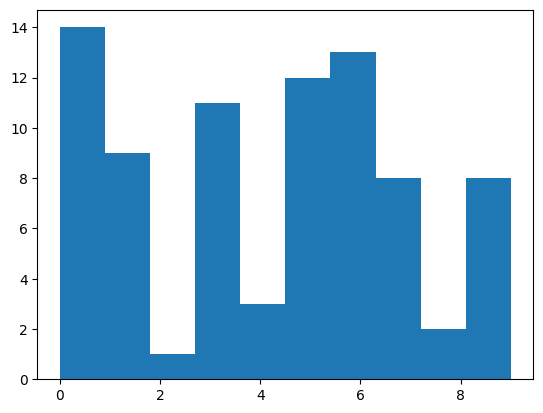

In [34]:
OPTIMAL_NUMBER_CLUSTERS = 10
SEED = 10

k_means = KMeans(n_clusters=OPTIMAL_NUMBER_CLUSTERS, random_state=SEED)
k_means.fit(water_series_anonimized)
cluster_labels = k_means.labels_

y, x, _ = plt.hist(cluster_labels)

In [35]:
id_cluster = dict()
for index in consumption_series:
    predicted = k_means.predict([consumption_series[index]])
    id_cluster[index] = predicted[0]
id_cluster

{0: 6,
 1: 6,
 2: 3,
 3: 7,
 4: 3,
 5: 9,
 6: 1,
 7: 6,
 8: 1,
 9: 9,
 10: 1,
 12: 5,
 13: 0,
 14: 5,
 15: 1,
 16: 0,
 17: 9,
 18: 3,
 19: 5,
 20: 0,
 21: 8,
 22: 7,
 24: 3,
 25: 6,
 27: 3,
 28: 7,
 29: 5,
 30: 3,
 31: 3,
 36: 5,
 38: 0,
 40: 0,
 41: 4,
 42: 5,
 43: 0,
 44: 6,
 45: 6,
 46: 6,
 47: 9,
 48: 3,
 49: 4,
 50: 7,
 51: 1,
 52: 5,
 53: 5,
 55: 9,
 56: 1,
 57: 9,
 58: 2,
 59: 0,
 60: 1,
 61: 6,
 63: 7,
 65: 5,
 66: 0,
 68: 6,
 69: 6,
 70: 1,
 71: 7,
 75: 4,
 77: 6,
 80: 3,
 81: 3,
 82: 0,
 83: 7,
 84: 1,
 86: 5,
 87: 8,
 88: 0,
 89: 0,
 90: 6,
 91: 6,
 92: 9,
 93: 9,
 94: 5,
 95: 0,
 96: 3,
 97: 5,
 98: 0,
 99: 0,
 100: 7}

In [36]:
UNCOMPLETE_SERIE_CLUSTER = 10

def assign_cluster_or_default(id, id_clusters):
  if id in id_clusters.keys():
    return id_clusters[id]
  else:
    return UNCOMPLETE_SERIE_CLUSTER

In [37]:
water_consumptions['cluster'] = water_consumptions.apply(lambda row: assign_cluster_or_default(row.id, id_cluster), axis = 1)
water_consumptions

,id,datetime,consumption,cluster
0,0,2019-02-01,243,6
1,0,2019-02-02,236,6
2,0,2019-02-03,335,6
3,0,2019-02-04,252,6
4,0,2019-02-05,220,6
...,...,...,...,...
35589,100,2020-01-27,471,7
35590,100,2020-01-28,445,7
35591,100,2020-01-29,720,7
35592,100,2020-01-30,402,7


## Training-test datasets
The dataset is a time series. A specific characteristic of a time serie is that in a train-test problem we have to use the first part for training and the second for testing. We can't shuffle the serie to get it balanced or make changes in the order. 
In this problem we picked the first eleven months (2019-02-01 / 2019-12-31), which are the 91% of the dataset, and left the other 9% (2020-01-01 / 2020-01-31) for testing purposes.

In [38]:
print('Datatime range:', min(water_consumptions['datetime']) ,max(water_consumptions['datetime']))

Datatime range: 2019-02-01 00:00:00 2020-01-31 00:00:00


In [39]:
def train_test_split(water_consumptions):
    train =  water_consumptions.loc[water_consumptions['datetime'] < datetime(2020, 1, 18)]
    test = water_consumptions.loc[water_consumptions['datetime'] >= datetime(2020, 1, 18)]
    return train, test

In [40]:
train_df, test_df = train_test_split(water_consumptions)
print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

Train shape: (34193, 4)
Test shape: (1401, 4)


In [41]:
import itertools
import statsmodels.api as sm

def sarima_grid_search(y, seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal
            except:
                continue
    return {
        'order': param_mini,
        'seasonal_order': param_seasonal_mini,
        'enforce_stationarity': False,
        'enforce_invertibility': False
    }
     

In [42]:
def cluster_grouped_ts(dataset, cluster_id) -> pd.DataFrame:
  cluster_series = dataset[dataset['cluster'] == cluster_id]
  cluster_series.drop(['id','cluster'], axis = 1, inplace = True)
  return cluster_series.groupby('datetime').sum()

def grid_search_by_cluster(dataset, seasonal_period=30) -> dict:
  best_params_per_cluster = {}
  for cluster_id in set(dataset.cluster):
    cluster_ts = cluster_grouped_ts(dataset, cluster_id)
    best_params_cluster = sarima_grid_search(cluster_ts, seasonal_period)
    best_params_per_cluster[cluster_id] = best_params_cluster
  return best_params_per_cluster

## Train-Predict by cluster

In [43]:
def generate_append_from_predictions(predicted, ts_id):
  week_1 = sum(predicted[:7])
  week_2 = sum(predicted[7:])
  days_week_consumptions = np.append(np.append(predicted[:7], week_1), week_2)
  return np.concatenate(([ts_id],days_week_consumptions))
  

def train_predict_by_id(train_dataset, model_per_cluster, params_per_cluster, scaler_per_cluster, default_model, default_params, default_scaler, predict_steps=14):
  column_names = ['id', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'week_1', 'week_2']
  df = pd.DataFrame(columns = column_names)
  ids = set(train_dataset['id'])
  for ts_id in ids:
    try:
      print('id: {id} de {len}, completado: {percent:.2f}%'.format(id=ts_id, len=len(ids), percent=(len(df)/len(ids))*100))
      current_id_time_serie = train_dataset[train_dataset['id'] == ts_id]
      cluster = list(current_id_time_serie['cluster'])[0]
      if cluster < UNCOMPLETE_SERIE_CLUSTER and model_per_cluster is not None:
        print('Cluster:', cluster)
        params = params_per_cluster[cluster]
        scaler = scaler_per_cluster[cluster]()
        model = model_per_cluster[cluster](**params, scaler=scaler)
      else:
        scaler = default_scaler()
        model = default_model(**default_params, scaler=scaler)

      model.train(current_id_time_serie)
      predicted = model.predict(predict_steps)
      to_append = generate_append_from_predictions(predicted, ts_id)
    
    except Exception as e:
      print(e)
      to_append = [ts_id, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    df.loc[len(df)] = to_append
  return df

In [44]:
from models.sarima_model import SarimaModel
from sklearn.preprocessing import MinMaxScaler

default_params = {
    'order': (1, 1, 1),
    'seasonal_order': (1, 1, 1, 30),
    'enforce_stationarity': False,
    'enforce_invertibility': False
}
default_model = SarimaModel
default_scaler = StandardScaler
params_by_cluster = grid_search_by_cluster(train_df)
models_by_cluer = {
    0: SarimaModel,
    1: SarimaModel,
    2: SarimaModel,
    3: SarimaModel,
    4: SarimaModel,
    5: SarimaModel,
    6: SarimaModel,
    7: SarimaModel,
    8: SarimaModel,
    9: SarimaModel,
    10: SarimaModel
}
scaler_by_cluster = {
    0: StandardScaler,
    1: MinMaxScaler,
    2: StandardScaler,
    3: MinMaxScaler,
    4: StandardScaler,
    5: MinMaxScaler,
    6: StandardScaler,
    7: MinMaxScaler,
    8: StandardScaler,
    9: MinMaxScaler,
    10: StandardScaler
}

/tmp/ipykernel_25436/284374044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_series.drop(['id','cluster'], axis = 1, inplace = True)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.54157D+00    |proj g|=  3.33600D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.336D-07   9.542D+00
  F =   9.5415734174717066     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.5

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34244D+00    |proj g|=  1.16921D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   9.238D-06   7.341D+00
  F =   7.3405915230425327     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10


 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.69497D+00    |proj g|=  3.02839D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   8.950D-05   6.647D+00
  F =   6.6472953299957140     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34616D+00    |proj g|=  1.04601D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     17      1     0     0   1.046D-04   7.346D+00
  F =   7.3461556976387286     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.6

 This problem is unconstrained.



At iterate   10    f=  7.32687D+00    |proj g|=  2.37974D-02

At iterate   15    f=  7.32685D+00    |proj g|=  1.46812D-03

At iterate   20    f=  7.32664D+00    |proj g|=  2.29191D-02

At iterate   25    f=  7.32051D+00    |proj g|=  6.79512D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     31      1     0     0   7.518D-06   7.319D+00
  F =   7.3188782729538699     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.66661D+00    |proj g|=  4.30891D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.309D-06   6.667D+00
  F =   6.6666111889071820     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.69086D+00    |proj g|=  3.12315D-01

At iterate    5    f=  6.64738D+00    |proj g|=  2.04627D-02

At iterate   10    f=  6.64654D+00    |proj g|=  3.59538D-04

At iterate   15    f=  6.64654D+00    |proj g|=  9.97272D-04

At iterate   20    f=  6.64638D+00    |proj g|=  1.35432D-02

At iterate   25    f=  6.64485D+00    |proj g|=  2.55922D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     34      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23390D+00    |proj g|=  2.64213D-01

At iterate    5    f=  9.18286D+00    |proj g|=  1.91107D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     10      1     0     0   1.911D-04   9.183D+00
  F =   9.1828635584123397     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.51350D+00    |proj g|=  1.30707D-01

At iterate    5    f=  6.50103D+00    |proj g|=  2.12783D-04

At iterate   10    f=  6.50102D+00    |proj g|=  5.37850D-03

At iterate   15    f=  6.49972D+00    |proj g|=  5.59757D-02

At iterate   20    f=  6.49306D+00    |proj g|=  9.43030D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     24      1     0     0   2.833D-06   6.493D+00
  F =   6.4930632841300255     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.30972D+00    |proj g|=  8.67930D-03

At iterate    5    f=  8.30920D+00    |proj g|=  2.54859D-04

At iterate   10    f=  8.30899D+00    |proj g|=  4.50863D-03

At iterate   15    f=  8.28814D+00    |proj g|=  8.25459D-02

At iterate   20    f=  7.42416D+00    |proj g|=  1.73843D+00

At iterate   25    f=  7.22897D+00    |proj g|=  5.20536D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     43      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.28271D+00    |proj g|=  2.07011D-01

At iterate    5    f=  8.25877D+00    |proj g|=  1.23819D-02

At iterate   10    f=  8.25726D+00    |proj g|=  2.60324D-04

At iterate   15    f=  8.25717D+00    |proj g|=  3.80432D-03

At iterate   20    f=  8.24466D+00    |proj g|=  8.60202D-02

At iterate   25    f=  7.87609D+00    |proj g|=  2.67052D-01

At iterate   30    f=  7.24054D+00    |proj g|=  5.79792D-01

At iterate   35    f=  7.16945D+00    |proj g|=  1.78423D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.54781D+00    |proj g|=  8.23834D-04

At iterate   10    f=  6.54767D+00    |proj g|=  1.89974D-02

At iterate   15    f=  6.54123D+00    |proj g|=  5.25114D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   3.994D-06   6.540D+00
  F =   6.5404528722363047     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.51176D+00    |proj g|=  1.32891D-01

At iterate    5    f=  6.50056D+00    |proj g|=  3.98403D-03

At iterate   10    f=  6.50050D+00    |proj g|=  2.33644D-04

At iterate   15    f=  6.50035D+00    |proj g|=  6.82058D-03

At iterate   20    f=  6.49187D+00    |proj g|=  7.61404D-02

At iterate   25    f=  6.48913D+00    |proj g|=  2.64658D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     36      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.60000D+00    |proj g|=  1.05660D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      2      1     0     0   2.704D-06   7.600D+00
  F =   7.5999928596366484     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.9

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.39958D+00    |proj g|=  9.32601D-02

At iterate    5    f=  6.39276D+00    |proj g|=  4.27053D-04

At iterate   10    f=  6.39264D+00    |proj g|=  1.33165D-02

At iterate   15    f=  6.37862D+00    |proj g|=  1.27350D-01

At iterate   20    f=  6.35579D+00    |proj g|=  9.66043D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     25      1     0     0   1.768D-06   6.356D+00
  F =   6.3557094309276527     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98199D+00    |proj g|=  4.60618D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.606D-06   6.982D+00
  F =   6.9819869842021980     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.9

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.42143D+00    |proj g|=  9.36361D-02

At iterate    5    f=  6.38290D+00    |proj g|=  7.69989D-04

At iterate   10    f=  6.38274D+00    |proj g|=  1.24017D-02

At iterate   15    f=  6.37006D+00    |proj g|=  1.13447D-01

At iterate   20    f=  6.35551D+00    |proj g|=  4.53371D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     27      1     0     0   1.612D-05   6.355D+00
  F =   6.3554981453900830     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.44819D+00    |proj g|=  1.41183D-01

At iterate    5    f=  7.43020D+00    |proj g|=  1.42221D-04

At iterate   10    f=  7.43019D+00    |proj g|=  4.56550D-03

At iterate   15    f=  7.42947D+00    |proj g|=  2.34436D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     19     23      1     0     0   9.226D-07   7.429D+00
  F =   7.4291293014029947     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  7.11560D+00    |proj g|=  6.62835D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   6.628D-05   7.116D+00
  F =   7.1155994854263422     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30110D+00    |proj g|=  7.68773D-02

At iterate    5    f=  6.28544D+00    |proj g|=  6.10418D-04

At iterate   10    f=  6.28527D+00    |proj g|=  1.56966D-02

At iterate   15    f=  6.26133D+00    |proj g|=  1.91144D-01

At iterate   20    f=  6.20575D+00    |proj g|=  1.82388D-02

At iterate   25    f=  6.20549D+00    |proj g|=  2.88569D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     31      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.86307D+00    |proj g|=  1.28231D-01

At iterate    5    f=  6.84693D+00    |proj g|=  6.54266D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   6.543D-05   6.847D+00
  F =   6.8469319300645273     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate   10    f=  6.80241D+00    |proj g|=  2.84241D-04

At iterate   15    f=  6.80239D+00    |proj g|=  3.26597D-03

At iterate   20    f=  6.80207D+00    |proj g|=  1.28531D-02

At iterate   25    f=  6.80189D+00    |proj g|=  3.26121D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     29      1     0     0   3.261D-06   6.802D+00
  F =   6.8018919712467998     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.40465D+00    |proj g|=  8.48630D-02

At iterate    5    f=  6.39355D+00    |proj g|=  3.58031D-04

At iterate   10    f=  6.39347D+00    |proj g|=  7.56641D-03

At iterate   15    f=  6.38488D+00    |proj g|=  8.63511D-02

At iterate   20    f=  6.37414D+00    |proj g|=  1.09518D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     25      1     0     0   4.843D-06   6.374D+00
  F =   6.3741391160798901     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.32374D+00    |proj g|=  7.96373D-02

At iterate    5    f=  6.28476D+00    |proj g|=  6.08831D-04

At iterate   10    f=  6.28468D+00    |proj g|=  7.15274D-03

At iterate   15    f=  6.27663D+00    |proj g|=  6.99208D-02

At iterate   20    f=  6.21162D+00    |proj g|=  6.07592D-02

At iterate   25    f=  6.20535D+00    |proj g|=  1.44362D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     30      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.61768D+00    |proj g|=  2.36553D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     16      1     0     0   2.365D-04   7.618D+00
  F =   7.6176764127825773     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.9

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.41290D+00    |proj g|=  2.13777D-01

At iterate    5    f=  6.37552D+00    |proj g|=  4.08577D-03

At iterate   10    f=  6.37550D+00    |proj g|=  2.37951D-03

At iterate   15    f=  6.37449D+00    |proj g|=  3.58991D-02

At iterate   20    f=  6.34245D+00    |proj g|=  3.12850D-02

At iterate   25    f=  6.34011D+00    |proj g|=  6.60091D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     31      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36966D+00    |proj g|=  8.62153D-01

At iterate    5    f=  6.97950D+00    |proj g|=  2.01717D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     17      1     0     0   5.656D-05   6.979D+00
  F =   6.9789631874342852     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.06587D+00    |proj g|=  5.19935D-01

At iterate    5    f=  7.01430D+00    |proj g|=  1.04026D-01

At iterate   10    f=  7.00930D+00    |proj g|=  1.27885D-01

At iterate   15    f=  6.97395D+00    |proj g|=  9.29053D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   2.026D-05   6.974D+00
  F =   6.9739513987180697     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.44690D+00    |proj g|=  1.65781D-01

At iterate    5    f=  6.42373D+00    |proj g|=  3.66333D-04

At iterate   10    f=  6.42368D+00    |proj g|=  9.06581D-03

At iterate   15    f=  6.41974D+00    |proj g|=  6.12204D-02

At iterate   20    f=  6.41700D+00    |proj g|=  5.09583D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     22      1     0     0   5.096D-06   6.417D+00
  F =   6.4169968672068425     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.40829D+00    |proj g|=  2.09988D-01

At iterate    5    f=  6.37480D+00    |proj g|=  8.18243D-04

At iterate   10    f=  6.37478D+00    |proj g|=  4.73329D-03

At iterate   15    f=  6.37284D+00    |proj g|=  5.85057D-02

At iterate   20    f=  6.33922D+00    |proj g|=  3.55588D-02

At iterate   25    f=  6.33699D+00    |proj g|=  1.61752D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     29      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.47626D+00    |proj g|=  1.53848D-01

At iterate    5    f=  7.45264D+00    |proj g|=  1.39646D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   2.039D-04   7.453D+00
  F =   7.4526348446690873     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa


At iterate    5    f=  7.11960D+00    |proj g|=  5.71045D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   1.762D-05   7.120D+00
  F =   7.1195990094004129     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.34475D+00    |proj g|=  2.44327D-01

At iterate    5    f=  6.29605D+00    |proj g|=  5.08277D-02

At iterate   10    f=  6.29315D+00    |proj g|=  3.57929D-03

At iterate   15    f=  6.29313D+00    |proj g|=  1.55603D-02

At iterate   20    f=  6.29132D+00    |proj g|=  1.56636D-01

At iterate   25    f=  6.23834D+00    |proj g|=  4.89783D-01

At iterate   30    f=  6.22700D+00    |proj g|=  1.93721D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.26286D+00    |proj g|=  8.49190D-01

At iterate    5    f=  6.86501D+00    |proj g|=  2.90896D-01

At iterate   10    f=  6.85448D+00    |proj g|=  2.26724D-01

At iterate   15    f=  6.84642D+00    |proj g|=  4.88955D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     43      1     0     0   2.225D-03   6.846D+00
  F =   6.8462396149992841     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.86527D+00    |proj g|=  1.24546D-01

At iterate   10    f=  6.84766D+00    |proj g|=  2.89158D-02

At iterate   15    f=  6.82802D+00    |proj g|=  1.00314D+00

At iterate   20    f=  6.82353D+00    |proj g|=  1.52824D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     31      1     0     0   3.320D-04   6.824D+00
  F =   6.8235280670116563     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.41723D+00    |proj g|=  2.02068D-01

At iterate    5    f=  6.38029D+00    |proj g|=  3.02706D-02

At iterate   10    f=  6.37997D+00    |proj g|=  1.47883D-03

At iterate   15    f=  6.37916D+00    |proj g|=  3.15473D-02

At iterate   20    f=  6.36714D+00    |proj g|=  3.35499D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     29      1     0     0   6.997D-05   6.366D+00
  F =   6.3664875486914045     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.34148D+00    |proj g|=  2.37713D-01

At iterate    5    f=  6.29368D+00    |proj g|=  8.25784D-02

At iterate   10    f=  6.29228D+00    |proj g|=  8.02981D-04

At iterate   15    f=  6.29226D+00    |proj g|=  4.44338D-03

At iterate   20    f=  6.29062D+00    |proj g|=  3.58234D-02

At iterate   25    f=  6.26716D+00    |proj g|=  1.06739D-01

At iterate   30    f=  6.22655D+00    |proj g|=  1.93110D-02

At iterate   35    f=  6.22632D+00    |proj g|=  2.47844D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.51588D+00    |proj g|=  5.88605D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.886D-06   7.516D+00
  F =   7.5158795135735827     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.8

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.19419D+00    |proj g|=  5.21467D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.215D-06   7.194D+00
  F =   7.1941861983113196     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.3

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.88356D+00    |proj g|=  2.93844D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   5.721D-05   6.883D+00
  F =   6.8830903141992312     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.8

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.41632D+00    |proj g|=  9.63729D-04

At iterate   10    f=  6.41600D+00    |proj g|=  1.62337D-02

At iterate   15    f=  6.40282D+00    |proj g|=  4.02753D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     21      1     0     0   2.591D-06   6.401D+00
  F =   6.4013416224917528     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.37890D+00    |proj g|=  7.86349D-02

At iterate    5    f=  6.35227D+00    |proj g|=  5.50615D-04

At iterate   10    f=  6.35215D+00    |proj g|=  9.57851D-03

At iterate   15    f=  6.33510D+00    |proj g|=  1.37239D-01

At iterate   20    f=  6.28514D+00    |proj g|=  4.30580D-02

At iterate   25    f=  6.28391D+00    |proj g|=  4.77574D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.43708D+00    |proj g|=  1.63185D-01

At iterate    5    f=  7.41540D+00    |proj g|=  7.34277D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   2.046D-04   7.415D+00
  F =   7.4153873646188924     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.11032D+00    |proj g|=  1.49423D-01

At iterate    5    f=  7.09470D+00    |proj g|=  1.82016D-02

At iterate   10    f=  7.09463D+00    |proj g|=  4.30317D-03

At iterate   15    f=  7.09341D+00    |proj g|=  4.69579D-02

At iterate   20    f=  7.09287D+00    |proj g|=  3.95417D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     26      1     0     0   3.954D-07   7.093D+00
  F =   7.0928734359232806     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.28970D+00    |proj g|=  9.43928D-02

At iterate    5    f=  6.27743D+00    |proj g|=  5.29069D-03

At iterate   10    f=  6.27732D+00    |proj g|=  5.31795D-03

At iterate   15    f=  6.26975D+00    |proj g|=  7.78024D-02

At iterate   20    f=  6.19587D+00    |proj g|=  4.64044D-02

At iterate   25    f=  6.19530D+00    |proj g|=  6.93951D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.83200D+00    |proj g|=  1.50632D-01

At iterate    5    f=  6.81209D+00    |proj g|=  1.95914D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.235D-04   6.812D+00
  F =   6.8120292185501095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.81271D+00    |proj g|=  1.51888D-01

At iterate    5    f=  6.79156D+00    |proj g|=  1.17063D-02

At iterate   10    f=  6.78988D+00    |proj g|=  1.03326D-02

At iterate   15    f=  6.78981D+00    |proj g|=  1.20593D-03

At iterate   20    f=  6.78959D+00    |proj g|=  1.70413D-02

At iterate   25    f=  6.78861D+00    |proj g|=  3.13729D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     30      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.36950D+00    |proj g|=  1.10740D-01

At iterate    5    f=  6.35788D+00    |proj g|=  5.00143D-03

At iterate   10    f=  6.35787D+00    |proj g|=  1.38795D-03

At iterate   15    f=  6.35740D+00    |proj g|=  2.47852D-02

At iterate   20    f=  6.33799D+00    |proj g|=  9.70125D-02

At iterate   25    f=  6.33395D+00    |proj g|=  1.21558D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     29      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.31165D+00    |proj g|=  1.02094D-01

At iterate    5    f=  6.27699D+00    |proj g|=  6.42856D-03

At iterate   10    f=  6.27688D+00    |proj g|=  1.14195D-03

At iterate   15    f=  6.27558D+00    |proj g|=  2.65209D-02

At iterate   20    f=  6.21989D+00    |proj g|=  1.20071D-01

At iterate   25    f=  6.19531D+00    |proj g|=  3.12159D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     37      1     0     0   

/tmp/ipykernel_25436/284374044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_series.drop(['id','cluster'], axis = 1, inplace = True)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.93126D+00    |proj g|=  4.96136D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   4.961D-07   8.931D+00
  F =   8.9312635253892214     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.2

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      5      1     0     0   3.829D-06   8.065D+00
  F =   8.0646863895696832     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.98936D+00    |proj g|=  1.20178D+00

At iterate    5    f=  7.19041D+00    |proj g|=  2.17686D-04

At iterate   10    f=  7.19023D+00    |proj g|=  1.07788D-02

At iterate   15    f=  7.13238D+00    |proj g|=  1.51149D-02

At iter

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.98609D+00    |proj g|=  7.46514D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   7.465D-06   7.986D+00
  F =   7.9860921425617528     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.5

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.25675D+00    |proj g|=  5.35074D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.351D-06   7.257D+00
  F =   7.2567496738143182     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.00854D+00    |proj g|=  1.16385D+00

At iterate    5    f=  7.19551D+00    |proj g|=  1.76611D-01

At iterate   10    f=  7.17887D+00    |proj g|=  1.12827D-04

At iterate   15    f=  7.17886D+00    |proj g|=  2.17812D-03

At iterate   20    f=  7.17764D+00    |proj g|=  2.70039D-02

At iterate   25    f=  7.13171D+00    |proj g|=  2.75989D-02

At iterate   30    f=  7.13076D+00    |proj g|=  1.67301D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00424D+01    |proj g|=  7.54549D+01

At iterate    5    f=  8.58156D+00    |proj g|=  4.20292D-02

At iterate   10    f=  8.58115D+00    |proj g|=  8.00515D-04

At iterate   15    f=  8.58109D+00    |proj g|=  1.65027D-02

At iterate   20    f=  8.57326D+00    |proj g|=  2.35654D-01

At iterate   25    f=  8.51885D+00    |proj g|=  4.45276D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     27     30      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14417D+00    |proj g|=  1.92765D+00

At iterate    5    f=  6.95437D+00    |proj g|=  6.44098D-03

At iterate   10    f=  6.95433D+00    |proj g|=  2.38871D-03

At iterate   15    f=  6.95353D+00    |proj g|=  3.96420D-02

At iterate   20    f=  6.90950D+00    |proj g|=  1.66295D-01

At iterate   25    f=  6.89372D+00    |proj g|=  9.07153D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     33      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.66495D+00    |proj g|=  2.11111D+01

At iterate    5    f=  7.83992D+00    |proj g|=  6.91661D-03

At iterate   10    f=  7.83986D+00    |proj g|=  2.42947D-03

At iterate   15    f=  7.83841D+00    |proj g|=  3.81936D-02

At iterate   20    f=  7.75424D+00    |proj g|=  2.40868D-01

At iterate   25    f=  7.73362D+00    |proj g|=  1.90595D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     31      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  7.80385D+00    |proj g|=  1.82634D-01

At iterate   10    f=  7.76985D+00    |proj g|=  1.37974D-02

At iterate   15    f=  7.76958D+00    |proj g|=  3.34011D-04

At iterate   20    f=  7.76943D+00    |proj g|=  1.21708D-02

At iterate   25    f=  7.73530D+00    |proj g|=  3.99579D-01

At iterate   30    f=  7.60491D+00    |proj g|=  1.96545D-02

At iterate   35    f=  7.60483D+00    |proj g|=  9.27347D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     38      1     0     0   9.273D-07   7.605D+00
  F =   7.6048293018076736     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  7.05870D+00    |proj g|=  1.73282D-03

At iterate   10    f=  7.05870D+00    |proj g|=  1.13823D-03

At iterate   15    f=  7.05845D+00    |proj g|=  1.76633D-02

At iterate   20    f=  7.04689D+00    |proj g|=  5.79967D-02

At iterate   25    f=  7.04466D+00    |proj g|=  6.18527D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     29      1     0     0   6.185D-07   7.045D+00
  F =   7.0446589483885242     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14591D+00    |proj g|=  1.94257D+00

At iterate    5    f=  6.95707D+00    |proj g|=  4.17020D-02

At iterate   10    f=  6.95416D+00    |proj g|=  2.55676D-04

At iterate   15    f=  6.95416D+00    |proj g|=  2.75883D-03

At iterate   20    f=  6.95339D+00    |proj g|=  3.26065D-02

At iterate   25    f=  6.93079D+00    |proj g|=  1.56023D-01

At iterate   30    f=  6.89373D+00    |proj g|=  2.92090D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18855D+00    |proj g|=  5.95488D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   5.955D-06   8.189D+00
  F =   8.1885538836469411     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.6

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84531D+00    |proj g|=  6.88531D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      5      1     0     0   4.416D-06   7.843D+00
  F =   7.8432726346328110     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.02412D+00    |proj g|=  5.06479D-01

At iterate    5    f=  6.88607D+00    |proj g|=  1.37783D-04

At iterate   10    f=  6.88607D+00    |proj g|=  2.95519D-03

At iterate   15    f=  6.88546D+00    |proj g|=  3.58207D-02

At iterate   20    f=  6.87726D+00    |proj g|=  2.65061D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     24     26      1     0     0   1.562D-06   6.877D+00
  F =   6.8767521939168503     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.53632D+00    |proj g|=  4.53610D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.536D-06   7.536D+00
  F =   7.5363190444489492     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.6

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.01765D+00    |proj g|=  5.36593D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.366D-06   7.018D+00
  F =   7.0176489575277525     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.09369D+00    |proj g|=  4.88372D-01

At iterate    5    f=  6.87943D+00    |proj g|=  2.38701D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   9.093D-05   6.879D+00
  F =   6.8790905131503743     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.16660D+00    |proj g|=  3.65403D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   6.866D-06   8.166D+00
  F =   8.1656593722441375     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.4

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   5.805D-06   7.818D+00
  F =   7.8184200342559800     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94135D+00    |proj g|=  1.58253D-01

At iterate    5    f=  6.91949D+00    |proj g|=  1.39848D-03

At iterate   10    f=  6.91948D+00    |proj g|=  2.64994D-03

At iterate   15    f=  6.91868D+00    |proj g|=  3.51496D-02

At iterate   20    f=  6.87791D+00    |proj g|=  1.91530D-01

At iterate   25    f=  6.85341D+00    |proj g|=  2.64698D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     30      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.53710D+00    |proj g|=  4.17686D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   5.309D-05   7.536D+00
  F =   7.5358643978888100     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.4

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     13      1     0     0   1.084D-04   7.490D+00
  F =   7.4897158281003673     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03238D+00    |proj g|=  2.05729D-02

At iterate    5    f=  7.03192D+00    |proj g|=  1.49545D-04

At iterate   10    f=  7.03190D+00    |proj g|=  4.75040D-03

At iterate   15    f=  7.02982D+00    |proj g|=  5.22240D-02

At iterate   20    f=  7.01688D+00    |proj g|=  1.60199D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     27      1     0     0   3.508D-06   7.017D+00
  F =   7.0168780620505302     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.95020D+00    |proj g|=  1.46829D-01

At iterate    5    f=  6.91494D+00    |proj g|=  1.69058D-03

At iterate   10    f=  6.91491D+00    |proj g|=  2.38683D-03

At iterate   15    f=  6.91265D+00    |proj g|=  3.43949D-02

At iterate   20    f=  6.85487D+00    |proj g|=  5.04282D-02

At iterate   25    f=  6.84940D+00    |proj g|=  1.96757D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     33      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18094D+00    |proj g|=  2.24066D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   2.229D-05   8.181D+00
  F =   8.1809434064267261     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.5

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.97242D+00    |proj g|=  2.51550D-01


 This problem is unconstrained.



At iterate    5    f=  6.89946D+00    |proj g|=  2.83413D-04

At iterate   10    f=  6.89941D+00    |proj g|=  7.16057D-03

At iterate   15    f=  6.89395D+00    |proj g|=  8.20481D-02

At iterate   20    f=  6.83973D+00    |proj g|=  3.74496D-02

At iterate   25    f=  6.83845D+00    |proj g|=  6.48424D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     29      1     0     0   6.484D-06   6.838D+00
  F =   6.8384522537211669     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.68578D+00    |proj g|=  5.83558D-01

At iterate    5    f=  7.50936D+00    |proj g|=  4.77051D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   1.098D-04   7.509D+00
  F =   7.5093476410479560     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  7.48169D+00    |proj g|=  1.50829D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     17      1     0     0   1.076D-04   7.482D+00
  F =   7.4815339361063025     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.96644D+00    |proj g|=  5.21343D-02

At iterate    5    f=  6.96424D+00    |proj g|=  3.75579D-03

At iterate   10    f=  6.95974D+00    |proj g|=  7.04249D-02

At iterate   15    f=  6.95201D+00    |proj g|=  7.18910D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     22      1     0     0   4.118D-07   6.952D+00
  F =   6.9520068305546907     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.97334D+00    |proj g|=  2.46413D-01

At iterate    5    f=  6.89652D+00    |proj g|=  3.49069D-03

At iterate   10    f=  6.89648D+00    |proj g|=  2.10820D-03

At iterate   15    f=  6.89586D+00    |proj g|=  3.15080D-02

At iterate   20    f=  6.85448D+00    |proj g|=  2.05562D-01

At iterate   25    f=  6.83640D+00    |proj g|=  4.29722D-03

At iterate   30    f=  6.83631D+00    |proj g|=  4.09098D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15329D+00    |proj g|=  6.34855D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   3.540D-06   8.153D+00
  F =   8.1532938371187793     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.4

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93521D+00    |proj g|=  2.44107D-01

At iterate    5    f=  6.86182D+00    |proj g|=  3.62651D-04

At iterate   10    f=  6.86181D+00    |proj g|=  3.36825D-03

At iterate   15    f=  6.86033D+00    |proj g|=  4.21656D-02

At iterate   20    f=  6.81746D+00    |proj g|=  9.35696D-02

At iterate   25    f=  6.80062D+00    |proj g|=  2.80805D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     31      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.67335D+00    |proj g|=  5.69809D-01

At iterate    5    f=  7.50305D+00    |proj g|=  5.22072D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   5.856D-05   7.503D+00
  F =   7.5030281365408529     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.47483D+00    |proj g|=  1.32655D-01

At iterate    5    f=  7.45337D+00    |proj g|=  1.80870D-02

At iterate   10    f=  7.45285D+00    |proj g|=  1.11306D-04

At iterate   15    f=  7.45285D+00    |proj g|=  9.87265D-04

At iterate   20    f=  7.45275D+00    |proj g|=  1.20023D-02

At iterate   25    f=  7.44900D+00    |proj g|=  1.90745D-02

At iterate   30    f=  7.44869D+00    |proj g|=  1.52015D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.95288D+00    |proj g|=  5.06096D-02

At iterate    5    f=  6.94915D+00    |proj g|=  1.52959D-04

At iterate   10    f=  6.94915D+00    |proj g|=  2.63799D-03

At iterate   15    f=  6.94850D+00    |proj g|=  3.01014D-02

At iterate   20    f=  6.93753D+00    |proj g|=  3.57822D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     28      1     0     0   3.165D-06   6.937D+00
  F =   6.9367547612027067     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93617D+00    |proj g|=  2.39005D-01

At iterate    5    f=  6.85938D+00    |proj g|=  3.60208D-03

At iterate   10    f=  6.85932D+00    |proj g|=  1.09409D-03

At iterate   15    f=  6.85849D+00    |proj g|=  1.67509D-02

At iterate   20    f=  6.81500D+00    |proj g|=  1.58001D-01

At iterate   25    f=  6.79874D+00    |proj g|=  6.84303D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     29      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18792D+00    |proj g|=  4.97771D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.978D-06   8.188D+00
  F =   8.1879240950346333     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.5

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.96276D+00    |proj g|=  1.60000D-01

At iterate    5    f=  6.94092D+00    |proj g|=  2.65511D-04

At iterate   10    f=  6.94090D+00    |proj g|=  3.32977D-03

At iterate   15    f=  6.93904D+00    |proj g|=  3.85452D-02

At iterate   20    f=  6.88663D+00    |proj g|=  9.88734D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     27      1     0     0   6.554D-06   6.876D+00
  F =   6.8758782827397127     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.51322D+00    |proj g|=  5.54832D-03

At iterate    5    f=  7.51319D+00    |proj g|=  3.34447D-03

At iterate   10    f=  7.51255D+00    |proj g|=  1.70611D-02

At iterate   15    f=  7.51230D+00    |proj g|=  1.41561D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     21      1     0     0   2.659D-07   7.512D+00
  F =   7.5123049583137735     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.51363D+00    |proj g|=  2.91115D-02

At iterate    5    f=  7.51319D+00    |proj g|=  7.03884D-04

At iterate   10    f=  7.51319D+00    |proj g|=  3.39699D-04

At iterate   15    f=  7.51318D+00    |proj g|=  4.65284D-03

At iterate   20    f=  7.51269D+00    |proj g|=  2.18044D-02

At iterate   25    f=  7.51230D+00    |proj g|=  7.55132D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     34      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.00792D+00    |proj g|=  6.37441D-03

At iterate    5    f=  7.00787D+00    |proj g|=  3.32605D-03

At iterate   10    f=  7.00613D+00    |proj g|=  5.00506D-02

At iterate   15    f=  6.99432D+00    |proj g|=  3.15904D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     22      1     0     0   3.690D-06   6.994D+00
  F =   6.9943073677713201     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.97177D+00    |proj g|=  1.48160D-01

At iterate    5    f=  6.93638D+00    |proj g|=  2.68202D-04

At iterate   10    f=  6.93637D+00    |proj g|=  1.72405D-03

At iterate   15    f=  6.93524D+00    |proj g|=  2.30995D-02

At iterate   20    f=  6.88947D+00    |proj g|=  1.62697D-01

At iterate   25    f=  6.87190D+00    |proj g|=  3.49367D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     34      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.60875D+00    |proj g|=  5.82581D-01

At iterate    5    f=  8.09740D+00    |proj g|=  1.03228D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     18      1     0     0   1.032D-04   8.096D+00
  F =   8.0958890624850959     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.38182D+00    |proj g|=  4.79314D-01

At iterate    5    f=  7.79247D+00    |proj g|=  1.70793D-01

At iterate   10    f=  7.74760D+00    |proj g|=  4.14344D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     22      1     0     0   6.505D-05   7.747D+00
  F =   7.7474734974672224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.44094D+00    |proj g|=  2.82580D-01

At iterate    5    f=  6.88522D+00    |proj g|=  1.14831D-01

At iterate   10    f=  6.87362D+00    |proj g|=  1.45665D-02

At iterate   15    f=  6.87349D+00    |proj g|=  1.48447D-03

At iterate   20    f=  6.87339D+00    |proj g|=  3.17856D-02

At iterate   25    f=  6.86234D+00    |proj g|=  1.03389D-01

At iterate   30    f=  6.84927D+00    |proj g|=  4.96004D-02

At iterate   35    f=  6.82481D+00    |proj g|=  1.78738D-01

At iterate   40    f=  6.79603D+00    |proj g|=  1.15941D-02

At iterate   45    f=  6.79573D+00    |proj g|=  2.29852D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.92163D+00    |proj g|=  5.70244D-01

At iterate    5    f=  7.44975D+00    |proj g|=  2.03314D-01

At iterate   10    f=  7.44833D+00    |proj g|=  1.29607D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   5.992D-05   7.448D+00
  F =   7.4483258763355655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  7.42690D+00    |proj g|=  1.78475D-01

At iterate   10    f=  7.42556D+00    |proj g|=  9.32934D-04

At iterate   15    f=  7.42553D+00    |proj g|=  5.41515D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   4.068D-05   7.426D+00
  F =   7.4255221215834641     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.51472D+00    |proj g|=  3.33966D-01

At iterate    5    f=  6.97656D+00    |proj g|=  1.76931D-01

At iterate   10    f=  6.95676D+00    |proj g|=  3.16323D-03

At iterate   15    f=  6.95676D+00    |proj g|=  1.85683D-04

At iterate   20    f=  6.95676D+00    |proj g|=  7.63019D-03

At iterate   25    f=  6.95585D+00    |proj g|=  7.22462D-02

At iterate   30    f=  6.94265D+00    |proj g|=  1.67340D-01

At iterate   35    f=  6.93409D+00    |proj g|=  5.67591D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.45108D+00    |proj g|=  2.94375D-01

At iterate    5    f=  6.88260D+00    |proj g|=  1.50799D-01

At iterate   10    f=  6.86994D+00    |proj g|=  6.47934D-03

At iterate   15    f=  6.86987D+00    |proj g|=  2.98181D-04

At iterate   20    f=  6.86971D+00    |proj g|=  1.02455D-02

At iterate   25    f=  6.85387D+00    |proj g|=  1.71530D-01

At iterate   30    f=  6.79304D+00    |proj g|=  6.24299D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/tmp/ipykernel_25436/284374044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_series.drop(['id','cluster'], axis = 1, inplace = True)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.00155D+00    |proj g|=  7.68630D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   7.686D-07   7.002D+00
  F =   7.0015474209263964     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.2

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.68341D+00    |proj g|=  7.09329D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   4.440D-06   5.682D+00
  F =   5.6816033118264349     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.9

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67906D+00    |proj g|=  2.33505D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     13      1     0     0   2.331D-05   5.679D+00
  F =   5.6790607153803165     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.5

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.99808D+00    |proj g|=  4.92644D-02

At iterate    5    f=  4.98676D+00    |proj g|=  1.08083D-03

At iterate   10    f=  4.98654D+00    |proj g|=  1.05597D-02

At iterate   15    f=  4.98197D+00    |proj g|=  3.83251D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   1.146D-07   4.982D+00
  F =   4.9819401121972273     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.80200D+00    |proj g|=  3.61152D-01

At iterate    5    f=  6.73890D+00    |proj g|=  5.32091D-03

At iterate   10    f=  6.73515D+00    |proj g|=  9.50105D-02

At iterate   15    f=  6.65591D+00    |proj g|=  6.32024D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     19     21      1     0     0   4.855D-06   6.654D+00
  F =   6.6538446487133651     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.99989D+00    |proj g|=  3.38557D-02


 This problem is unconstrained.



At iterate    5    f=  4.99883D+00    |proj g|=  8.39313D-03

At iterate   10    f=  4.98553D+00    |proj g|=  1.00058D-01

At iterate   15    f=  4.96391D+00    |proj g|=  9.79215D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     22      1     0     0   9.497D-06   4.964D+00
  F =   4.9638458003896995     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.05785D+00    |proj g|=  7.20574D-02

At iterate    5    f=  6.04927D+00    |proj g|=  2.71961D-03

At iterate   10    f=  6.03205D+00    |proj g|=  1.67505D-01

At iterate   15    f=  5.67934D+00    |proj g|=  6.99786D-02

At iterate   20    f=  5.67692D+00    |proj g|=  3.65485D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     25      1     0     0   3.655D-06   5.677D+00
  F =   5.6769186113094596     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04942D+00    |proj g|=  2.80186D-01

At iterate    5    f=  5.99946D+00    |proj g|=  1.81273D-02

At iterate   10    f=  5.99828D+00    |proj g|=  6.02416D-03

At iterate   15    f=  5.95375D+00    |proj g|=  1.35984D-01

At iterate   20    f=  5.58059D+00    |proj g|=  2.83243D-01

At iterate   25    f=  5.47414D+00    |proj g|=  2.65912D-01

At iterate   30    f=  5.47240D+00    |proj g|=  1.38504D-03

At iterate   35    f=  5.47239D+00    |proj g|=  1.30786D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.07013D+00    |proj g|=  1.99425D-02

At iterate    5    f=  5.06962D+00    |proj g|=  1.30483D-02

At iterate   10    f=  5.05737D+00    |proj g|=  5.48443D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     20      1     0     0   3.452D-06   5.056D+00
  F =   5.0556560061579852     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.00604D+00    |proj g|=  4.17756D-02

At iterate    5    f=  4.99844D+00    |proj g|=  2.35419D-03

At iterate   10    f=  4.99057D+00    |proj g|=  5.11358D-02

At iterate   15    f=  4.96425D+00    |proj g|=  1.79337D-02

At iterate   20    f=  4.96379D+00    |proj g|=  5.56506D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   2.694D-05   4.964D+00
  F =   4.9637919723422534     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.21164D+00    |proj g|=  3.67527D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   2.398D-09   6.212D+00
  F =   6.2116312313415509     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.6

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.26277D+00    |proj g|=  4.60145D-02


 This problem is unconstrained.



At iterate    5    f=  5.26117D+00    |proj g|=  7.46084D-03

At iterate   10    f=  5.25125D+00    |proj g|=  1.10150D-01

At iterate   15    f=  5.20132D+00    |proj g|=  2.48983D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     19     21      1     0     0   1.202D-07   5.201D+00
  F =   5.2013024127613345     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67412D+00    |proj g|=  4.96634D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.966D-06   5.674D+00
  F =   5.6741199754728973     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.6

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.30114D+00    |proj g|=  5.42739D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.427D-06   5.301D+00
  F =   5.3011388125872685     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.26049D+00    |proj g|=  1.13621D-01

At iterate    5    f=  5.21571D+00    |proj g|=  2.38685D-03

At iterate   10    f=  5.21078D+00    |proj g|=  6.79945D-02

At iterate   15    f=  5.19347D+00    |proj g|=  6.48299D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     24      1     0     0   4.320D-06   5.193D+00
  F =   5.1934236631104058     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.90545D+00    |proj g|=  2.62981D-01

At iterate    5    f=  5.87057D+00    |proj g|=  1.93398D-03

At iterate   10    f=  5.87049D+00    |proj g|=  2.71392D-02

At iterate   15    f=  5.86302D+00    |proj g|=  2.45715D-01

At iterate   20    f=  5.85988D+00    |proj g|=  7.59082D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     20     23      1     0     0   7.591D-06   5.860D+00
  F =   5.8598844058426556     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.68186D+00    |proj g|=  2.22217D-01

At iterate    5    f=  5.65560D+00    |proj g|=  1.28215D-03

At iterate   10    f=  5.65552D+00    |proj g|=  2.36151D-02

At iterate   15    f=  5.64887D+00    |proj g|=  1.78787D-01

At iterate   20    f=  5.64582D+00    |proj g|=  5.52536D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     20     23      1     0     0   5.525D-07   5.646D+00
  F =   5.6458168548139520     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.01365D+00    |proj g|=  1.22459D-01

At iterate    5    f=  5.00027D+00    |proj g|=  3.14360D-03

At iterate   10    f=  4.98316D+00    |proj g|=  1.72637D-01

At iterate   15    f=  4.90194D+00    |proj g|=  1.46221D-02

At iterate   20    f=  4.90178D+00    |proj g|=  6.84296D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     29      1     0     0   2.752D-06   4.902D+00
  F =   4.9017763133935368     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.41461D+00    |proj g|=  2.26066D-01

At iterate    5    f=  5.38606D+00    |proj g|=  2.93057D-03

At iterate   10    f=  5.38601D+00    |proj g|=  1.32480D-02

At iterate   15    f=  5.38093D+00    |proj g|=  7.51409D-02

At iterate   20    f=  5.37306D+00    |proj g|=  2.00666D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     26      1     0     0   2.951D-06   5.373D+00
  F =   5.3730591659421236     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.38467D+00    |proj g|=  2.28404D-01

At iterate    5    f=  5.35397D+00    |proj g|=  1.19073D-02

At iterate   10    f=  5.35346D+00    |proj g|=  3.66567D-03

At iterate   15    f=  5.35147D+00    |proj g|=  4.82305D-02

At iterate   20    f=  5.34097D+00    |proj g|=  6.44026D-03

At iterate   25    f=  5.34097D+00    |proj g|=  2.18238D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     30      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.08625D+00    |proj g|=  1.47284D-01

At iterate    5    f=  5.06948D+00    |proj g|=  2.47009D-03

At iterate   10    f=  5.06457D+00    |proj g|=  6.69076D-02

At iterate   15    f=  5.02162D+00    |proj g|=  4.53445D-02

At iterate   20    f=  5.02113D+00    |proj g|=  1.13081D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     28      1     0     0   1.131D-05   5.021D+00
  F =   5.0211337740711341     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.03747D+00    |proj g|=  1.38456D-01

At iterate    5    f=  4.99877D+00    |proj g|=  6.72672D-03

At iterate   10    f=  4.99682D+00    |proj g|=  2.34375D-02

At iterate   15    f=  4.95775D+00    |proj g|=  1.29598D-01

At iterate   20    f=  4.90043D+00    |proj g|=  1.02183D-02

At iterate   25    f=  4.89997D+00    |proj g|=  2.21711D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20093D+00    |proj g|=  2.48868D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     13      1     0     0   2.489D-05   6.201D+00
  F =   6.2009288708542201     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.6

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.01519D+00    |proj g|=  3.18304D-02

At iterate    5    f=  5.01405D+00    |proj g|=  6.90546D-03

At iterate   10    f=  5.00193D+00    |proj g|=  8.98722D-02

At iterate   15    f=  4.97908D+00    |proj g|=  5.02911D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     22      1     0     0   9.322D-06   4.979D+00
  F =   4.9790364389501809     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95942D+00    |proj g|=  7.68240D-01

At iterate    5    f=  5.67244D+00    |proj g|=  2.14632D-01

At iterate   10    f=  5.64798D+00    |proj g|=  3.53777D-04

At iterate   15    f=  5.64784D+00    |proj g|=  1.33563D-02

At iterate   20    f=  5.64746D+00    |proj g|=  2.46910D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     32      1     0     0   3.079D-05   5.647D+00
  F =   5.6474596938161934     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.71877D+00    |proj g|=  4.21222D-01

At iterate    5    f=  5.54367D+00    |proj g|=  7.10977D-02

At iterate   10    f=  5.53751D+00    |proj g|=  2.74673D-03

At iterate   15    f=  5.51581D+00    |proj g|=  4.03289D-01

At iterate   20    f=  5.49016D+00    |proj g|=  8.88434D-04

At iterate   25    f=  5.49016D+00    |proj g|=  8.66838D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     51      1     0     0   2.239D-05   5.490D+00
  F =   5.4901554838872366     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.05241D+00    |proj g|=  2.00805D-02

At iterate    5    f=  5.05143D+00    |proj g|=  2.32321D-02

At iterate   10    f=  5.03871D+00    |proj g|=  8.22786D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.02197D+00    |proj g|=  3.97190D-02

At iterate    5    f=  5.01372D+00    |proj g|=  2.62178D-03

At iterate   10    f=  5.01238D+00    |proj g|=  3.51205D-02

At iterate   15    f=  4.98278D+00    |proj g|=  2.22295D-02

At iterate   20    f=  4.98144D+00    |proj g|=  5.28443D-02

At iterate   25    f=  4.97882D+00    |proj g|=  2.64396D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     38      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94103D+00    |proj g|=  4.19378D-01

At iterate    5    f=  5.90145D+00    |proj g|=  2.33758D+00

At iterate   10    f=  5.89317D+00    |proj g|=  2.13934D-03

At iterate   15    f=  5.89306D+00    |proj g|=  4.51328D-01

At iterate   20    f=  5.88358D+00    |proj g|=  3.34687D+00

At iterate   25    f=  5.87944D+00    |proj g|=  1.13343D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     40      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  5.37940D+00    |proj g|=  1.13430D+00

At iterate   10    f=  5.37407D+00    |proj g|=  2.44687D-02

At iterate   15    f=  5.37375D+00    |proj g|=  1.07972D-01

At iterate   20    f=  5.37374D+00    |proj g|=  1.49061D-02

At iterate   25    f=  5.37363D+00    |proj g|=  1.28014D-01

At iterate   30    f=  5.36840D+00    |proj g|=  1.34046D+00

At iterate   35    f=  5.35727D+00    |proj g|=  1.11306D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     56      1     0     0   5.056D-04   5.357D+00
  F =   5.3572644641979696     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.65520D+00    |proj g|=  5.83654D-02

At iterate   10    f=  5.65479D+00    |proj g|=  2.03687D-04

At iterate   15    f=  5.65475D+00    |proj g|=  6.90273D-03

At iterate   20    f=  5.65461D+00    |proj g|=  6.48817D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     47      1     0     0   7.187D-07   5.655D+00
  F =   5.6546132037972709     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.99958D+00    |proj g|=  4.92529D-02

At iterate    5    f=  4.99159D+00    |proj g|=  1.19749D-01

At iterate   10    f=  4.97541D+00    |proj g|=  5.42187D-02

At iterate   15    f=  4.97408D+00    |proj g|=  6.91968D-03

At iterate   20    f=  4.96977D+00    |proj g|=  2.34792D-01

At iterate   25    f=  4.91722D+00    |proj g|=  2.42402D-01

At iterate   30    f=  4.91517D+00    |proj g|=  2.26968D-03

At iterate   35    f=  4.91516D+00    |proj g|=  1.81446D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.72892D+00    |proj g|=  7.06732D-01

At iterate    5    f=  5.46624D+00    |proj g|=  8.12569D-01

At iterate   10    f=  5.39060D+00    |proj g|=  1.32768D-01

At iterate   15    f=  5.39042D+00    |proj g|=  2.33657D-02

At iterate   20    f=  5.39042D+00    |proj g|=  1.48303D-02

At iterate   25    f=  5.39039D+00    |proj g|=  1.49711D-01

At iterate   30    f=  5.38844D+00    |proj g|=  7.82595D-01

At iterate   35    f=  5.37728D+00    |proj g|=  9.01590D-01

At iterate   40    f=  5.37384D+00    |proj g|=  1.22512D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.50269D+00    |proj g|=  3.97992D-01

At iterate    5    f=  5.41881D+00    |proj g|=  7.27340D-01

At iterate   10    f=  5.40586D+00    |proj g|=  7.28377D-01

At iterate   15    f=  5.37416D+00    |proj g|=  1.55127D-01

At iterate   20    f=  5.37366D+00    |proj g|=  1.30621D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     36      1     0     0   2.211D-03   5.374D+00
  F =   5.3736430168542828     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.05093D+00    |proj g|=  4.00745D-02

At iterate   10    f=  5.03932D+00    |proj g|=  7.59907D-02

At iterate   15    f=  5.03540D+00    |proj g|=  1.84177D-03

At iterate   20    f=  5.03523D+00    |proj g|=  1.57347D-02

At iterate   25    f=  5.02557D+00    |proj g|=  1.20167D-01

At iterate   30    f=  5.01626D+00    |proj g|=  1.15250D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     53      1     0     0   2.517D-06   5.016D+00
  F =   5.0162541700988346     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.00591D+00    |proj g|=  5.55446D-02

At iterate    5    f=  4.99712D+00    |proj g|=  2.35691D-02

At iterate   10    f=  4.99199D+00    |proj g|=  1.03307D-01

At iterate   15    f=  4.97361D+00    |proj g|=  6.45265D-02

At iterate   20    f=  4.97087D+00    |proj g|=  2.87659D-03

At iterate   25    f=  4.97043D+00    |proj g|=  1.78211D-02

At iterate   30    f=  4.94393D+00    |proj g|=  2.02494D-01

At iterate   35    f=  4.91119D+00    |proj g|=  6.49557D-02

At iterate   40    f=  4.91072D+00    |proj g|=  2.50709D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04522D+00    |proj g|=  6.90230D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   6.902D-06   6.045D+00
  F =   6.0452191563553663     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.5

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.10467D+00    |proj g|=  3.93549D-02

At iterate    5    f=  5.10285D+00    |proj g|=  2.08372D-02

At iterate   10    f=  5.06934D+00    |proj g|=  1.48378D-01

At iterate   15    f=  5.05263D+00    |proj g|=  5.18962D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     21      1     0     0   1.544D-06   5.053D+00
  F =   5.0526329902372957     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.50622D+00    |proj g|=  3.92314D-02

At iterate    5    f=  5.50540D+00    |proj g|=  1.14001D-03

At iterate   10    f=  5.50523D+00    |proj g|=  1.61553D-02

At iterate   15    f=  5.50495D+00    |proj g|=  2.80536D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     18      1     0     0   7.109D-07   5.505D+00
  F =   5.5049457899069560     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.50728D+00    |proj g|=  2.40447D-02

At iterate    5    f=  5.50540D+00    |proj g|=  3.80328D-04

At iterate   10    f=  5.50531D+00    |proj g|=  9.89862D-03

At iterate   15    f=  5.50495D+00    |proj g|=  7.40158D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     24      1     0     0   2.708D-05   5.505D+00
  F =   5.5049453995747637     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.15030D+00    |proj g|=  7.70507D-03

At iterate   10    f=  5.14343D+00    |proj g|=  8.75764D-02

At iterate   15    f=  5.13512D+00    |proj g|=  1.01841D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     19      1     0     0   2.319D-07   5.135D+00
  F =   5.1351151938774473     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.13631D+00    |proj g|=  6.91115D-02

At iterate    5    f=  5.10177D+00    |proj g|=  2.33458D-03

At iterate   10    f=  5.09978D+00    |proj g|=  2.88372D-02

At iterate   15    f=  5.05296D+00    |proj g|=  1.97410D-02

At iterate   20    f=  5.05244D+00    |proj g|=  5.03917D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     25      1     0     0   6.078D-06   5.052D+00
  F =   5.0524436080775779     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92226D+00    |proj g|=  2.38131D-01

At iterate    5    f=  5.86884D+00    |proj g|=  3.41129D-03

At iterate   10    f=  5.86875D+00    |proj g|=  2.42834D-02

At iterate   15    f=  5.86413D+00    |proj g|=  1.45663D-01

At iterate   20    f=  5.85868D+00    |proj g|=  1.11143D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     26      1     0     0   9.922D-07   5.859D+00
  F =   5.8586812764668537     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70439D+00    |proj g|=  1.76624D-01

At iterate    5    f=  5.65255D+00    |proj g|=  2.43685D-02

At iterate   10    f=  5.65127D+00    |proj g|=  5.65970D-02

At iterate   15    f=  5.64456D+00    |proj g|=  2.69084D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     24      1     0     0   1.866D-05   5.645D+00
  F =   5.6445544219837549     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.02158D+00    |proj g|=  1.10036D-01

At iterate    5    f=  4.99386D+00    |proj g|=  1.43188D-02

At iterate   10    f=  4.99274D+00    |proj g|=  2.45976D-02

At iterate   15    f=  4.91269D+00    |proj g|=  1.30522D-01

At iterate   20    f=  4.89867D+00    |proj g|=  1.54102D-02

At iterate   25    f=  4.89856D+00    |proj g|=  2.08915D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.41217D+00    |proj g|=  2.05731D-01

At iterate    5    f=  5.36784D+00    |proj g|=  6.46816D-03

At iterate   10    f=  5.36753D+00    |proj g|=  3.85688D-02

At iterate   15    f=  5.35855D+00    |proj g|=  1.14426D-01

At iterate   20    f=  5.35549D+00    |proj g|=  3.03973D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   3.040D-05   5.355D+00
  F =   5.3554904675869599     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.39803D+00    |proj g|=  2.08939D-01

At iterate    5    f=  5.35233D+00    |proj g|=  2.44049D-02

At iterate   10    f=  5.35182D+00    |proj g|=  7.80216D-03

At iterate   15    f=  5.35164D+00    |proj g|=  2.14463D-02

At iterate   20    f=  5.34393D+00    |proj g|=  1.15989D-01

At iterate   25    f=  5.33979D+00    |proj g|=  8.03198D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     34      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.08101D+00    |proj g|=  1.30258D-01

At iterate    5    f=  5.04622D+00    |proj g|=  3.85019D-02

At iterate   10    f=  5.04578D+00    |proj g|=  5.08856D-03

At iterate   15    f=  5.03844D+00    |proj g|=  9.41662D-02

At iterate   20    f=  5.00166D+00    |proj g|=  6.46009D-02

At iterate   25    f=  5.00082D+00    |proj g|=  4.19949D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     29      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.05006D+00    |proj g|=  1.23348D-01

At iterate    5    f=  4.99319D+00    |proj g|=  1.56686D-02

At iterate   10    f=  4.99186D+00    |proj g|=  3.59852D-03

At iterate   15    f=  4.98806D+00    |proj g|=  7.38927D-02

At iterate   20    f=  4.95423D+00    |proj g|=  1.36368D-01

At iterate   25    f=  4.89893D+00    |proj g|=  4.71160D-02

At iterate   30    f=  4.89659D+00    |proj g|=  4.48297D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/tmp/ipykernel_25436/284374044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_series.drop(['id','cluster'], axis = 1, inplace = True)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77849D+00    |proj g|=  4.58122D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   4.581D-07   9.778D+00
  F =   9.7784932319133837     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.8

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.72356D+00    |proj g|=  2.25779D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      5      1     0     0   8.685D-05   7.723D+00
  F =   7.7233804129887496     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.58816D+00    |proj g|=  1.05969D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     13      1     0     0   1.055D-05   8.588D+00
  F =   8.5881632632497844     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.6

 This problem is unconstrained.



At iterate   10    f=  8.46265D+00    |proj g|=  1.00496D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   1.167D-04   8.463D+00
  F =   8.4626537247221805     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.79224D+00    |proj g|=  4.94440D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73755D+00    |proj g|=  7.91917D-02

At iterate    5    f=  7.71042D+00    |proj g|=  2.81857D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   7.347D-05   7.710D+00
  F =   7.7104176847895083     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.49923D+00    |proj g|=  5.75117D+00

At iterate    5    f=  9.39556D+00    |proj g|=  3.93652D-03

At iterate   10    f=  9.39537D+00    |proj g|=  2.28164D-02

At iterate   15    f=  9.37983D+00    |proj g|=  2.08648D-01

At iterate   20    f=  9.25776D+00    |proj g|=  3.60267D-01

At iterate   25    f=  9.23701D+00    |proj g|=  1.34915D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     27     42      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa


At iterate    5    f=  8.29353D+00    |proj g|=  3.95807D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7      9      1     0     0   7.788D-05   8.294D+00
  F =   8.2935292504459035     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.45546D+00    |proj g|=  6.05121D-01


 This problem is unconstrained.



At iterate    5    f=  7.43063D+00    |proj g|=  7.90675D-03

At iterate   10    f=  7.43061D+00    |proj g|=  1.65843D-03

At iterate   15    f=  7.43026D+00    |proj g|=  2.53882D-02

At iterate   20    f=  7.41016D+00    |proj g|=  1.57625D-01

At iterate   25    f=  7.37754D+00    |proj g|=  2.49932D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     33      1     0     0   9.099D-06   7.378D+00
  F =   7.3775361182561854     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.62755D+00    |proj g|=  1.81434D+00

At iterate    5    f=  8.56738D+00    |proj g|=  3.48054D-03

At iterate   10    f=  8.56736D+00    |proj g|=  4.23529D-04

At iterate   15    f=  8.56728D+00    |proj g|=  7.22526D-03

At iterate   20    f=  8.55710D+00    |proj g|=  8.50859D-02

At iterate   25    f=  8.26115D+00    |proj g|=  1.58578D-01

At iterate   30    f=  8.25565D+00    |proj g|=  2.34190D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61370D+00    |proj g|=  3.71085D+00

At iterate    5    f=  8.49960D+00    |proj g|=  3.16234D-02

At iterate   10    f=  8.49729D+00    |proj g|=  5.84240D-03

At iterate   15    f=  8.49723D+00    |proj g|=  4.05400D-04

At iterate   20    f=  8.49718D+00    |proj g|=  6.62278D-03

At iterate   25    f=  8.49093D+00    |proj g|=  8.30241D-02

At iterate   30    f=  8.37384D+00    |proj g|=  1.61910D-01

At iterate   35    f=  8.22858D+00    |proj g|=  2.73967D-01

At iterate   40    f=  8.10938D+00    |proj g|=  3.71116D-02

At iterate   45    f=  8.10931D+00    |proj g|=  2.56897D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54867D+00    |proj g|=  5.80107D-01

At iterate    5    f=  7.52598D+00    |proj g|=  1.89896D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   1.031D-04   7.526D+00
  F =   7.5259792242987587     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.47916D+00    |proj g|=  6.65269D-01

At iterate    5    f=  7.43424D+00    |proj g|=  3.08545D-02

At iterate   10    f=  7.43058D+00    |proj g|=  1.40448D-04

At iterate   15    f=  7.43057D+00    |proj g|=  3.48204D-03

At iterate   20    f=  7.42984D+00    |proj g|=  4.46971D-02

At iterate   25    f=  7.39502D+00    |proj g|=  3.37677D-01

At iterate   30    f=  7.37754D+00    |proj g|=  6.31960D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71003D+00    |proj g|=  3.26956D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.270D-06   8.710D+00
  F =   8.7100300270664821     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.9

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.30947D+00    |proj g|=  4.19009D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      5      1     0     0   3.278D-06   8.307D+00
  F =   8.3073847693324723     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35241D+00    |proj g|=  1.46338D-01

At iterate    5    f=  7.33790D+00    |proj g|=  1.46164D-04

At iterate   10    f=  7.33789D+00    |proj g|=  2.71332D-03

At iterate   15    f=  7.33744D+00    |proj g|=  3.38976D-02

At iterate   20    f=  7.29949D+00    |proj g|=  1.17778D-01

At iterate   25    f=  7.29047D+00    |proj g|=  3.40096D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     26     28      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.99969D+00    |proj g|=  4.53220D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.532D-06   8.000D+00
  F =   7.9996880597090811     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.9

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.46788D+00    |proj g|=  5.34950D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.349D-06   7.468D+00
  F =   7.4678812001917860     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.38008D+00    |proj g|=  1.51199D-01

At iterate    5    f=  7.32685D+00    |proj g|=  1.36355D-04

At iterate   10    f=  7.32685D+00    |proj g|=  1.60073D-03

At iterate   15    f=  7.32619D+00    |proj g|=  2.05807D-02

At iterate   20    f=  7.30157D+00    |proj g|=  1.28289D-01

At iterate   25    f=  7.28888D+00    |proj g|=  4.75831D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     31      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.68643D+00    |proj g|=  1.41838D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      5      1     0     0   2.736D-06   8.686D+00
  F =   8.6864304775968755     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.9

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.28268D+00    |proj g|=  1.69530D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      7      1     0     0   1.733D-06   8.283D+00
  F =   8.2826790771322454     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34455D+00    |proj g|=  1.27709D-01

At iterate    5    f=  7.33273D+00    |proj g|=  1.25116D-03

At iterate   10    f=  7.33272D+00    |proj g|=  8.48550D-04

At iterate   15    f=  7.33263D+00    |proj g|=  1.27745D-02

At iterate   20    f=  7.32282D+00    |proj g|=  1.19919D-01

At iterate   25    f=  7.26665D+00    |proj g|=  9.03944D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     31      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.99987D+00    |proj g|=  7.11993D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      7      1     0     0   1.336D-05   8.000D+00
  F =   7.9998034408612320     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.9

 This problem is unconstrained.



At iterate   10    f=  7.95123D+00    |proj g|=  1.46814D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   1.281D-05   7.951D+00
  F =   7.9512328186115049     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.47608D+00    |proj g|=  2.28510D-02

At iterate    5    f=  7.47522D+00    |proj g|=  1.81002D-04

At iterate   10    f=  7.47512D+00    |proj g|=  7.65591D-03

At iterate   15    f=  7.46842D+00    |proj g|=  3.91121D-02

At iterate   20    f=  7.46632D+00    |proj g|=  1.20091D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     27      1     0     0   1.201D-06   7.466D+00
  F =   7.4663167069791214     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.37377D+00    |proj g|=  1.25939D-01

At iterate    5    f=  7.33134D+00    |proj g|=  1.66311D-03

At iterate   10    f=  7.33133D+00    |proj g|=  5.32949D-04

At iterate   15    f=  7.33124D+00    |proj g|=  1.06513D-02

At iterate   20    f=  7.32135D+00    |proj g|=  1.04838D-01

At iterate   25    f=  7.26607D+00    |proj g|=  3.54784D-02

At iterate   30    f=  7.26495D+00    |proj g|=  9.82858D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71864D+00    |proj g|=  4.17202D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     13      1     0     0   4.155D-05   8.719D+00
  F =   8.7186366409088727     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.0

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35028D+00    |proj g|=  1.21603D-01

At iterate    5    f=  7.33629D+00    |proj g|=  1.58308D-04

At iterate   10    f=  7.33628D+00    |proj g|=  2.91960D-03

At iterate   15    f=  7.33571D+00    |proj g|=  3.67737D-02

At iterate   20    f=  7.29177D+00    |proj g|=  2.00801D-01

At iterate   25    f=  7.28397D+00    |proj g|=  4.69230D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     32      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.27928D+00    |proj g|=  7.39569D-01

At iterate    5    f=  7.98692D+00    |proj g|=  1.79213D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   2.050D-05   7.987D+00
  F =   7.9868758648142837     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate   10    f=  7.98770D+00    |proj g|=  7.79091D-02

At iterate   15    f=  7.98651D+00    |proj g|=  1.77672D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     21      1     0     0   1.918D-05   7.987D+00
  F =   7.9865051865164682     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    0    f=  7.42371D+00    |proj g|=  5.25117D-02

At iterate    5    f=  7.42145D+00    |proj g|=  1.25041D-03

At iterate   10    f=  7.42103D+00    |proj g|=  2.56890D-02

At iterate   15    f=  7.41507D+00    |proj g|=  2.09976D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     24      1     0     0   1.632D-06   7.415D+00
  F =   7.4148004211762482     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.38297D+00    |proj g|=  1.17499D-01


 This problem is unconstrained.



At iterate    5    f=  7.33546D+00    |proj g|=  3.94485D-04

At iterate   10    f=  7.33544D+00    |proj g|=  2.52850D-03

At iterate   15    f=  7.33344D+00    |proj g|=  3.44225D-02

At iterate   20    f=  7.28912D+00    |proj g|=  1.54765D-01

At iterate   25    f=  7.28374D+00    |proj g|=  1.66222D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     32      1     0     0   2.135D-07   7.284D+00
  F =   7.2837343431797708     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.69431D+00    |proj g|=  1.13199D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      9      1     0     0   3.063D-06   8.694D+00
  F =   8.6941340227716655     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.9

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  8.21445D+00    |proj g|=  1.18259D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   9.228D-06   8.214D+00
  F =   8.2144492513613940     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31147D+00    |proj g|=  1.02381D-01

At iterate    5    f=  7.30017D+00    |proj g|=  1.54544D-03

At iterate   10    f=  7.30017D+00    |proj g|=  8.60071D-04

At iterate   15    f=  7.30009D+00    |proj g|=  1.21175D-02

At iterate   20    f=  7.29176D+00    |proj g|=  1.32007D-01

At iterate   25    f=  7.25412D+00    |proj g|=  3.38165D-02

At iterate   30    f=  7.25343D+00    |proj g|=  3.83242D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.27482D+00    |proj g|=  7.32302D-01

At iterate    5    f=  7.98759D+00    |proj g|=  3.22582D-02

At iterate   10    f=  7.98570D+00    |proj g|=  1.56055D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   1.561D-05   7.986D+00
  F =   7.9856966102372455     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.99977D+00    |proj g|=  3.11505D-01

At iterate    5    f=  7.96644D+00    |proj g|=  3.19454D-02

At iterate   10    f=  7.96239D+00    |proj g|=  1.41020D-02

At iterate   15    f=  7.96179D+00    |proj g|=  8.07625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   1.643D-05   7.962D+00
  F =   7.9617926877506893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.40408D+00    |proj g|=  4.91222D-02

At iterate    5    f=  7.40063D+00    |proj g|=  1.78699D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     10      1     0     0   7.354D-05   7.401D+00
  F =   7.4006263090184161     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34195D+00    |proj g|=  1.06105D-01


 This problem is unconstrained.



At iterate    5    f=  7.29961D+00    |proj g|=  5.17344D-03

At iterate   10    f=  7.29950D+00    |proj g|=  1.55351D-04

At iterate   15    f=  7.29949D+00    |proj g|=  3.74512D-03

At iterate   20    f=  7.29799D+00    |proj g|=  4.49949D-02

At iterate   25    f=  7.25920D+00    |proj g|=  9.82853D-02

At iterate   30    f=  7.25325D+00    |proj g|=  1.52433D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     36      1     0     0   3.115D-05   7.253D+00
  F =   7.2532487627380622     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71000D+00    |proj g|=  4.97433D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.974D-06   8.710D+00
  F =   8.7100036950024364     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.9

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.30735D+00    |proj g|=  4.54889D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.549D-06   8.307D+00
  F =   8.3073476873127383     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.3

 This problem is unconstrained.



At iterate    5    f=  7.35607D+00    |proj g|=  2.64237D-04

At iterate   10    f=  7.35606D+00    |proj g|=  1.18577D-03

At iterate   15    f=  7.35576D+00    |proj g|=  1.56786D-02

At iterate   20    f=  7.32799D+00    |proj g|=  1.52478D-01

At iterate   25    f=  7.29037D+00    |proj g|=  6.33116D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     31      1     0     0   2.013D-06   7.290D+00
  F =   7.2903703205221229     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.97623D+00    |proj g|=  5.50632D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   1.935D-05   7.976D+00
  F =   7.9762165973582162     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.9

 This problem is unconstrained.



At iterate    5    f=  7.97600D+00    |proj g|=  2.65311D-02

At iterate   10    f=  7.97492D+00    |proj g|=  1.54902D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   1.549D-05   7.975D+00
  F =   7.9749168091504101     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.45111D+00    |proj g|=  2.32833D-02

At iterate    5    f=  7.45070D+00    |proj g|=  3.09975D-04

At iterate   10    f=  7.45068D+00    |proj g|=  6.73530D-03

At iterate   15    f=  7.44795D+00    |proj g|=  6.10033D-02

At iterate   20    f=  7.44282D+00    |proj g|=  4.23731D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     24      1     0     0   1.778D-06   7.443D+00
  F =   7.4428227414028667     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.39761D+00    |proj g|=  1.26993D-01

At iterate    5    f=  7.35470D+00    |proj g|=  1.71292D-03

At iterate   10    f=  7.35470D+00    |proj g|=  4.37433D-04

At iterate   15    f=  7.35461D+00    |proj g|=  7.55685D-03

At iterate   20    f=  7.34495D+00    |proj g|=  7.87854D-02

At iterate   25    f=  7.28985D+00    |proj g|=  4.04041D-02

At iterate   30    f=  7.28877D+00    |proj g|=  2.43063D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.68567D+00    |proj g|=  3.68654D-02

At iterate    5    f=  8.62979D+00    |proj g|=  4.66241D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     19      1     0     0   2.603D-04   8.630D+00
  F =   8.6297838071992974     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.28237D+00    |proj g|=  2.13258D-02

At iterate    5    f=  8.26037D+00    |proj g|=  1.32966D-01

At iterate   10    f=  8.25813D+00    |proj g|=  3.53459D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     21      1     0     0   2.320D-05   8.258D+00
  F =   8.2581332803520962     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34434D+00    |proj g|=  1.27673D-01

At iterate    5    f=  7.33230D+00    |proj g|=  3.66471D-03

At iterate   10    f=  7.32962D+00    |proj g|=  4.50499D-02

At iterate   15    f=  7.32642D+00    |proj g|=  3.93958D-04

At iterate   20    f=  7.32642D+00    |proj g|=  1.99006D-03

At iterate   25    f=  7.32600D+00    |proj g|=  2.83994D-02

At iterate   30    f=  7.27864D+00    |proj g|=  1.80831D-01

At iterate   35    f=  7.25403D+00    |proj g|=  1.75213D-02

At iterate   40    f=  7.25392D+00    |proj g|=  9.46372D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.97549D+00    |proj g|=  2.90160D-02

At iterate    5    f=  7.91903D+00    |proj g|=  5.63390D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     20      1     0     0   5.981D-05   7.919D+00
  F =   7.9190237586616323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.95292D+00    |proj g|=  2.80139D-02

At iterate    5    f=  7.91849D+00    |proj g|=  1.89660D-01

At iterate   10    f=  7.89426D+00    |proj g|=  2.37598D-03

At iterate   15    f=  7.89394D+00    |proj g|=  3.81407D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     29      1     0     0   6.217D-05   7.894D+00
  F =   7.8939383323560772     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.45122D+00    |proj g|=  3.45168D-02

At iterate    5    f=  7.43840D+00    |proj g|=  1.35119D-01

At iterate   10    f=  7.43595D+00    |proj g|=  2.22112D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     24      1     0     0   8.212D-05   7.436D+00
  F =   7.4359473919631478     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.37356D+00    |proj g|=  1.25891D-01


 This problem is unconstrained.



At iterate    5    f=  7.33086D+00    |proj g|=  3.49244D-03

At iterate   10    f=  7.32863D+00    |proj g|=  8.12581D-02

At iterate   15    f=  7.32558D+00    |proj g|=  7.79469D-04

At iterate   20    f=  7.32558D+00    |proj g|=  8.26913D-04

At iterate   25    f=  7.32535D+00    |proj g|=  1.29421D-02

At iterate   30    f=  7.30995D+00    |proj g|=  1.05251D-01

At iterate   35    f=  7.25720D+00    |proj g|=  2.42354D-02

At iterate   40    f=  7.25325D+00    |proj g|=  1.41058D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     61      1     0     0   5.996D-06   7.253D+00
  F =   7.25321146521

/tmp/ipykernel_25436/284374044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_series.drop(['id','cluster'], axis = 1, inplace = True)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13298D+00    |proj g|=  6.05622D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   6.056D-06   7.133D+00
  F =   7.1329773260550349     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.4

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.43997D+00    |proj g|=  1.17509D-01

At iterate    5    f=  5.40845D+00    |proj g|=  9.33277D-04

At iterate   10    f=  5.40825D+00    |proj g|=  1.73121D-02

At iterate   15    f=  5.39696D+00    |proj g|=  4.99356D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     19     22      1     0     0   2.802D-06   5.395D+00
  F =   5.3954464128624426     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.07982D+00    |proj g|=  1.26944D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     13      1     0     0   1.263D-05   6.080D+00
  F =   6.0798249524425945     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.0

 This problem is unconstrained.



At iterate   10    f=  5.97474D+00    |proj g|=  1.96170D-03

At iterate   15    f=  5.97471D+00    |proj g|=  3.55982D-02

At iterate   20    f=  5.97194D+00    |proj g|=  3.03776D-01

At iterate   25    f=  5.96854D+00    |proj g|=  6.57274D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     42      1     0     0   3.229D-05   5.969D+00
  F =   5.9685355112188709     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.45604D+00    |proj g|=  7.47522D-02

At iterate    5    f=  5.40204D+00    |proj g|=  9.88399D-04

At iterate   10    f=  5.40118D+00    |proj g|=  3.92655D-02

At iterate   15    f=  5.38764D+00    |proj g|=  4.42587D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     24      1     0     0   7.309D-07   5.388D+00
  F =   5.3876009480635458     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.20110D+00    |proj g|=  1.01360D+00

At iterate    5    f=  6.99975D+00    |proj g|=  4.21127D-03

At iterate   10    f=  6.99727D+00    |proj g|=  8.03906D-02

At iterate   15    f=  6.98453D+00    |proj g|=  3.66644D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     16     19      1     0     0   9.431D-06   6.985D+00
  F =   6.9845284372181347     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.42093D+00    |proj g|=  1.11584D-01


 This problem is unconstrained.



At iterate    5    f=  5.39497D+00    |proj g|=  1.38013D-03

At iterate   10    f=  5.39277D+00    |proj g|=  5.70094D-02

At iterate   15    f=  5.36252D+00    |proj g|=  4.70677D-02

At iterate   20    f=  5.36066D+00    |proj g|=  3.31056D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     24      1     0     0   1.881D-06   5.361D+00
  F =   5.3606597899956903     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.25176D+00    |proj g|=  3.79196D-02

At iterate    5    f=  6.25052D+00    |proj g|=  1.88490D-03

At iterate   10    f=  6.24556D+00    |proj g|=  5.47432D-02

At iterate   15    f=  6.12763D+00    |proj g|=  3.01874D-01

At iterate   20    f=  6.07790D+00    |proj g|=  1.71934D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     24      1     0     0   1.719D-06   6.078D+00
  F =   6.0779038458731351     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22830D+00    |proj g|=  5.84860D-01

At iterate    5    f=  6.19772D+00    |proj g|=  4.80827D-02

At iterate   10    f=  6.19630D+00    |proj g|=  6.71360D-03

At iterate   15    f=  6.19396D+00    |proj g|=  6.41707D-02

At iterate   20    f=  6.16463D+00    |proj g|=  2.13083D-01

At iterate   25    f=  5.99442D+00    |proj g|=  1.79551D-01

At iterate   30    f=  5.92610D+00    |proj g|=  2.07591D-02

At iterate   35    f=  5.92585D+00    |proj g|=  9.32028D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    0    f=  5.49748D+00    |proj g|=  1.15899D-01

At iterate    5    f=  5.49287D+00    |proj g|=  1.78348D-03

At iterate   10    f=  5.49247D+00    |proj g|=  2.28211D-02

At iterate   15    f=  5.49040D+00    |proj g|=  1.35911D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   7.846D-06   5.490D+00
  F =   5.4903981535662467     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.43390D+00    |proj g|=  7.91930D-02

At iterate    5    f=  5.39233D+00    |proj g|=  5.41578D-03

At iterate   10    f=  5.39219D+00    |proj g|=  1.18381D-02

At iterate   15    f=  5.37962D+00    |proj g|=  1.49647D-01

At iterate   20    f=  5.35589D+00    |proj g|=  4.93360D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   1.066D-05   5.356D+00
  F =   5.3558855778019794     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.89149D+00    |proj g|=  2.29454D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      2      1     0     0   9.611D-06   6.891D+00
  F =   6.8914823045486093     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.2

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.48087D+00    |proj g|=  2.85672D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      5      1     0     0   1.011D-06   6.479D+00
  F =   6.4791025269427065     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.7

 This problem is unconstrained.



At iterate    5    f=  5.77524D+00    |proj g|=  1.78098D-03

At iterate   10    f=  5.77450D+00    |proj g|=  3.18609D-02

At iterate   15    f=  5.76350D+00    |proj g|=  1.66976D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     23      1     0     0   6.788D-06   5.763D+00
  F =   5.7631809203803961     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.27903D+00    |proj g|=  5.14886D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.149D-06   6.279D+00
  F =   6.2790269954259070     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.2

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.82267D+00    |proj g|=  1.55645D-01

At iterate    5    f=  5.75999D+00    |proj g|=  8.98308D-02

At iterate   10    f=  5.75511D+00    |proj g|=  1.65046D-03

At iterate   15    f=  5.75432D+00    |proj g|=  3.59179D-02

At iterate   20    f=  5.74208D+00    |proj g|=  4.13460D-02

At iterate   25    f=  5.74099D+00    |proj g|=  6.07159D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     32      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.48611D+00    |proj g|=  5.15444D-01

At iterate    5    f=  6.41590D+00    |proj g|=  1.56083D-03

At iterate   10    f=  6.40780D+00    |proj g|=  2.04249D-01

At iterate   15    f=  6.39137D+00    |proj g|=  2.61979D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     25      1     0     0   1.423D-07   6.391D+00
  F =   6.3912710775324397     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.08720D+00    |proj g|=  2.51848D-01

At iterate    5    f=  6.06738D+00    |proj g|=  1.74292D-02

At iterate   10    f=  6.06246D+00    |proj g|=  1.31416D-01

At iterate   15    f=  6.06083D+00    |proj g|=  1.04450D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     20      1     0     0   1.044D-07   6.061D+00
  F =   6.0608298332943331     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.45320D+00    |proj g|=  3.71685D-01

At iterate    5    f=  5.41235D+00    |proj g|=  2.10223D-02

At iterate   10    f=  5.41129D+00    |proj g|=  1.69037D-02

At iterate   15    f=  5.39225D+00    |proj g|=  8.98411D-02

At iterate   20    f=  5.35319D+00    |proj g|=  4.33582D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     26      1     0     0   7.593D-06   5.353D+00
  F =   5.3531922707856223     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95201D+00    |proj g|=  4.69689D-01

At iterate    5    f=  5.88551D+00    |proj g|=  6.90996D-03

At iterate   10    f=  5.88545D+00    |proj g|=  1.38165D-02

At iterate   15    f=  5.88110D+00    |proj g|=  1.45368D-01

At iterate   20    f=  5.85696D+00    |proj g|=  6.44597D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     26      1     0     0   8.043D-06   5.857D+00
  F =   5.8569360443740290     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.84401D+00    |proj g|=  2.92124D-02

At iterate   10    f=  5.84090D+00    |proj g|=  3.30576D-03

At iterate   15    f=  5.84084D+00    |proj g|=  1.68960D-02

At iterate   20    f=  5.83463D+00    |proj g|=  1.63610D-01

At iterate   25    f=  5.80858D+00    |proj g|=  1.08276D-02

At iterate   30    f=  5.80844D+00    |proj g|=  1.08838D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     35      1     0     0   1.088D-05   5.808D+00
  F =   5.8084441787581413     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.51467D+00    |proj g|=  2.95182D-01

At iterate    5    f=  5.48814D+00    |proj g|=  1.05593D-03

At iterate   10    f=  5.48796D+00    |proj g|=  2.01062D-02

At iterate   15    f=  5.47518D+00    |proj g|=  1.55339D-01

At iterate   20    f=  5.46947D+00    |proj g|=  9.74630D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   4.325D-07   5.469D+00
  F =   5.4694696961174092     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.47051D+00    |proj g|=  3.31309D-01

At iterate    5    f=  5.43137D+00    |proj g|=  8.85034D-02

At iterate   10    f=  5.41068D+00    |proj g|=  1.61055D-03

At iterate   15    f=  5.41031D+00    |proj g|=  1.50693D-02

At iterate   20    f=  5.37580D+00    |proj g|=  1.81610D-01

At iterate   25    f=  5.34937D+00    |proj g|=  4.56952D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.82288D+00    |proj g|=  9.29239D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   9.292D-06   6.823D+00
  F =   6.8228824652590543     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.1

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.09750D+00    |proj g|=  4.68727D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.687D-06   6.097D+00
  F =   6.0974978751787940     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.4

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.26612D+00    |proj g|=  4.66032D-01

At iterate    5    f=  6.08975D+00    |proj g|=  1.14245D-02

At iterate   10    f=  6.08937D+00    |proj g|=  1.14963D-02

At iterate   15    f=  6.06459D+00    |proj g|=  8.39806D-02

At iterate   20    f=  6.05863D+00    |proj g|=  5.38547D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     24      1     0     0   5.385D-06   6.059D+00
  F =   6.0586258633532184     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.04316D+00    |proj g|=  3.32618D-02

At iterate   10    f=  6.04110D+00    |proj g|=  2.02128D-03

At iterate   15    f=  6.04105D+00    |proj g|=  2.79155D-02

At iterate   20    f=  6.03496D+00    |proj g|=  2.57567D-01

At iterate   25    f=  5.99422D+00    |proj g|=  2.68207D-01

At iterate   30    f=  5.93265D+00    |proj g|=  7.07286D-02

At iterate   35    f=  5.93058D+00    |proj g|=  5.80928D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     44      1     0     0   5.145D-05   5.931D+00
  F =   5.9305808507772904     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.47017D+00    |proj g|=  1.49958D-03

At iterate   10    f=  5.46956D+00    |proj g|=  2.47786D-02

At iterate   15    f=  5.46605D+00    |proj g|=  1.33546D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     19      1     0     0   1.864D-06   5.466D+00
  F =   5.4660502690026140     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.44371D+00    |proj g|=  7.73154D-02

At iterate    5    f=  5.40411D+00    |proj g|=  4.45603D-03

At iterate   10    f=  5.40358D+00    |proj g|=  1.63238D-02

At iterate   15    f=  5.37024D+00    |proj g|=  1.09819D-01

At iterate   20    f=  5.35929D+00    |proj g|=  6.34410D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   1.014D-05   5.359D+00
  F =   5.3592895149346216     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.45464D+00    |proj g|=  2.27798D+00

At iterate    5    f=  6.42974D+00    |proj g|=  2.67018D+00

At iterate   10    f=  6.41905D+00    |proj g|=  8.29962D-01

At iterate   15    f=  6.41858D+00    |proj g|=  1.07703D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     42      1     0     0   1.077D-03   6.419D+00
  F =   6.4185812964513929     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  5.86102D+00    |proj g|=  7.84300D-02

At iterate   10    f=  5.84920D+00    |proj g|=  2.77786D-02

At iterate   15    f=  5.84913D+00    |proj g|=  2.75883D-03

At iterate   20    f=  5.84911D+00    |proj g|=  4.70531D-02

At iterate   25    f=  5.84808D+00    |proj g|=  1.15898D+00

At iterate   30    f=  5.83589D+00    |proj g|=  3.48997D-02

At iterate   35    f=  5.83572D+00    |proj g|=  5.97556D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     59      1     0     0   5.976D-04   5.836D+00
  F =   5.8357231396175955     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.43160D+00    |proj g|=  1.60115D-01

At iterate    5    f=  5.38628D+00    |proj g|=  6.28829D-02

At iterate   10    f=  5.37987D+00    |proj g|=  1.51586D-03

At iterate   15    f=  5.37860D+00    |proj g|=  3.49504D-02

At iterate   20    f=  5.34384D+00    |proj g|=  7.95175D-02

At iterate   25    f=  5.33776D+00    |proj g|=  6.60180D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     37      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.01253D+00    |proj g|=  3.84510D-01

At iterate    5    f=  5.92563D+00    |proj g|=  4.73015D-01

At iterate   10    f=  5.87205D+00    |proj g|=  1.94751D-01

At iterate   15    f=  5.87043D+00    |proj g|=  1.16209D-03

At iterate   20    f=  5.87034D+00    |proj g|=  8.69396D-02

At iterate   25    f=  5.86456D+00    |proj g|=  9.13179D-02

At iterate   30    f=  5.85819D+00    |proj g|=  7.22910D-03

At iterate   35    f=  5.85818D+00    |proj g|=  2.06848D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94467D+00    |proj g|=  2.91316D-01

At iterate    5    f=  5.92042D+00    |proj g|=  2.35607D-01

At iterate   10    f=  5.89764D+00    |proj g|=  5.69313D-01

At iterate   15    f=  5.88576D+00    |proj g|=  4.77492D-01

At iterate   20    f=  5.85020D+00    |proj g|=  2.28651D-01

At iterate   25    f=  5.84903D+00    |proj g|=  1.20356D-03

At iterate   30    f=  5.84902D+00    |proj g|=  1.31579D-02

At iterate   35    f=  5.84868D+00    |proj g|=  1.22267D-01

At iterate   40    f=  5.84261D+00    |proj g|=  1.97121D-01

At iterate   45    f=  5.83575D+00    |proj g|=  1.38579D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.49259D+00    |proj g|=  2.20551D-01

At iterate    5    f=  5.47837D+00    |proj g|=  8.23788D-02

At iterate   10    f=  5.46130D+00    |proj g|=  8.24667D-03

At iterate   15    f=  5.46099D+00    |proj g|=  5.75832D-04

At iterate   20    f=  5.46055D+00    |proj g|=  1.66188D-02

At iterate   25    f=  5.45698D+00    |proj g|=  2.79307D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     34      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.44530D+00    |proj g|=  1.69179D-01

At iterate    5    f=  5.39986D+00    |proj g|=  1.19369D-01

At iterate   10    f=  5.38236D+00    |proj g|=  6.13409D-02

At iterate   15    f=  5.37839D+00    |proj g|=  1.54152D-03

At iterate   20    f=  5.37797D+00    |proj g|=  1.76114D-02

At iterate   25    f=  5.34693D+00    |proj g|=  1.15561D-01

At iterate   30    f=  5.33475D+00    |proj g|=  6.66210D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.49968D+00    |proj g|=  1.09326D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     14      1     0     0   1.091D-05   6.500D+00
  F =   6.4996757666872131     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.9

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20013D+00    |proj g|=  8.44116D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   8.441D-06   6.200D+00
  F =   6.2001260842235908     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.5

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.93020D+00    |proj g|=  1.51529D-01

At iterate    5    f=  5.91742D+00    |proj g|=  1.78175D-03

At iterate   10    f=  5.91709D+00    |proj g|=  2.26469D-02

At iterate   15    f=  5.91679D+00    |proj g|=  5.40066D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   5.401D-06   5.917D+00
  F =   5.9167916071701825     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92515D+00    |proj g|=  5.75195D-02

At iterate    5    f=  5.91274D+00    |proj g|=  4.02602D-04

At iterate   10    f=  5.91257D+00    |proj g|=  5.54025D-03

At iterate   15    f=  5.91159D+00    |proj g|=  9.16283D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     24      1     0     0   1.735D-06   5.912D+00
  F =   5.9115859615288606     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.53555D+00    |proj g|=  8.75605D-03

At iterate   10    f=  5.52704D+00    |proj g|=  3.70420D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     19      1     0     0   1.091D-05   5.526D+00
  F =   5.5264004796772177     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.52319D+00    |proj g|=  7.64129D-02

At iterate    5    f=  5.48676D+00    |proj g|=  1.39986D-03

At iterate   10    f=  5.48637D+00    |proj g|=  1.89964D-02

At iterate   15    f=  5.45199D+00    |proj g|=  1.09950D-01

At iterate   20    f=  5.43804D+00    |proj g|=  1.38001D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     34      1     0     0   2.611D-06   5.438D+00
  F =   5.4379658096032557     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30962D+00    |proj g|=  1.86461D-01

At iterate    5    f=  6.28700D+00    |proj g|=  1.04711D-03

At iterate   10    f=  6.28576D+00    |proj g|=  3.55507D-02

At iterate   15    f=  6.28021D+00    |proj g|=  5.17370D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     23      1     0     0   2.034D-06   6.280D+00
  F =   6.2801947348122056     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.01419D+00    |proj g|=  1.32398D-01

At iterate    5    f=  6.00670D+00    |proj g|=  5.60829D-04

At iterate   10    f=  6.00630D+00    |proj g|=  2.92348D-02

At iterate   15    f=  6.00313D+00    |proj g|=  3.64527D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     21      1     0     0   1.561D-06   6.003D+00
  F =   6.0031206177986949     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.35600D+00    |proj g|=  1.10318D-01

At iterate    5    f=  5.33225D+00    |proj g|=  1.82521D-03

At iterate   10    f=  5.33099D+00    |proj g|=  3.06382D-02

At iterate   15    f=  5.28914D+00    |proj g|=  1.77762D-01

At iterate   20    f=  5.26622D+00    |proj g|=  5.04855D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     26      1     0     0   1.265D-05   5.266D+00
  F =   5.2662196797016891     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77694D+00    |proj g|=  1.32608D-01

At iterate    5    f=  5.75158D+00    |proj g|=  1.11429D-03

At iterate   10    f=  5.75148D+00    |proj g|=  7.91707D-03

At iterate   15    f=  5.74535D+00    |proj g|=  4.70954D-02

At iterate   20    f=  5.74301D+00    |proj g|=  1.54313D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   8.192D-06   5.743D+00
  F =   5.7430060105869369     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.75475D+00    |proj g|=  1.38313D-01

At iterate    5    f=  5.73606D+00    |proj g|=  1.77482D-02

At iterate   10    f=  5.73230D+00    |proj g|=  1.15119D-03

At iterate   15    f=  5.73212D+00    |proj g|=  1.04853D-02

At iterate   20    f=  5.72717D+00    |proj g|=  5.26844D-02

At iterate   25    f=  5.72298D+00    |proj g|=  2.12103D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     30      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.40803D+00    |proj g|=  1.06579D-01

At iterate    5    f=  5.39607D+00    |proj g|=  1.15719D-03

At iterate   10    f=  5.39521D+00    |proj g|=  2.62549D-02

At iterate   15    f=  5.37892D+00    |proj g|=  5.28333D-02

At iterate   20    f=  5.37714D+00    |proj g|=  4.69633D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     23      1     0     0   4.696D-06   5.377D+00
  F =   5.3771415757691896     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.37595D+00    |proj g|=  1.19149D-01

At iterate    5    f=  5.33629D+00    |proj g|=  4.55144D-02

At iterate   10    f=  5.33195D+00    |proj g|=  1.83081D-03

At iterate   15    f=  5.33062D+00    |proj g|=  3.08836D-02

At iterate   20    f=  5.27648D+00    |proj g|=  1.29865D-01

At iterate   25    f=  5.26550D+00    |proj g|=  2.49416D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     35      1     0     0   

/tmp/ipykernel_25436/284374044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_series.drop(['id','cluster'], axis = 1, inplace = True)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12178D+01    |proj g|=  5.68434D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   5.684D-09   1.122D+01
  F =   11.217821607603144     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.0

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.97696D+00    |proj g|=  9.71639D-02

At iterate    5    f=  8.97416D+00    |proj g|=  1.47093D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      8      1     0     0   1.471D-05   8.974D+00
  F =   8.9741579396586211     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00471D+01    |proj g|=  7.98721D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   7.987D-06   1.005D+01
  F =   10.047053156498405     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.0

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02399D+00    |proj g|=  1.83310D-01

At iterate    5    f=  8.96047D+00    |proj g|=  3.32941D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     16      1     0     0   8.378D-06   8.960D+00
  F =   8.9604561996708441     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08859D+01    |proj g|=  1.85577D-01

At iterate    5    f=  1.08800D+01    |proj g|=  2.67649D-03

At iterate   10    f=  1.08787D+01    |proj g|=  6.11554D-02

At iterate   15    f=  1.08373D+01    |proj g|=  1.36716D-01

At iterate   20    f=  1.08330D+01    |proj g|=  1.73097D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     20     30      1     0     0   1.731D-05   1.083D+01
  F =   10.832959594487518     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.85890D+00    |proj g|=  1.22040D-01


 This problem is unconstrained.



At iterate    5    f=  8.84964D+00    |proj g|=  1.95108D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   2.687D-05   8.850D+00
  F =   8.8496387338085274     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.99865D+00    |proj g|=  4.67018D-01

At iterate    5    f=  9.95401D+00    |proj g|=  2.15719D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   2.719D-05   9.954D+00
  F =   9.9540078690448688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  9.85120D+00    |proj g|=  4.34015D-02

At iterate   10    f=  9.84870D+00    |proj g|=  6.76197D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   3.230D-05   9.849D+00
  F =   9.8486970486478675     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.98927D+00    |proj g|=  7.13057D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   1.661D-05   8.985D+00
  F =   8.9848162481463376     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.89308D+00    |proj g|=  1.23294D-01

At iterate    5    f=  8.84695D+00    |proj g|=  1.81350D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   2.725D-05   8.847D+00
  F =   8.8467702624366815     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06837D+01    |proj g|=  3.30402D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.304D-08   1.068D+01
  F =   10.683697624948765     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.7

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02006D+01    |proj g|=  4.51159D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   4.512D-06   1.020D+01
  F =   10.200588327388722     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.9

 This problem is unconstrained.



At iterate    5    f=  8.93794D+00    |proj g|=  2.62899D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     10      1     0     0   2.629D-05   8.938D+00
  F =   8.9379431003617071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75429D+00    |proj g|=  5.21574D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.216D-06   9.754D+00
  F =   9.7542921931151767     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.7

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.09042D+00    |proj g|=  6.59863D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   6.599D-06   9.090D+00
  F =   9.0904199520868882     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.00650D+00    |proj g|=  1.93908D-01

At iterate    5    f=  8.85188D+00    |proj g|=  4.63436D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     12      1     0     0   2.185D-05   8.852D+00
  F =   8.8518797283240040     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06392D+01    |proj g|=  6.35124D-02

At iterate    5    f=  1.05602D+01    |proj g|=  1.35396D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   1.354D-05   1.056D+01
  F =   10.560185462348327     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01524D+01    |proj g|=  8.34060D-02

At iterate    5    f=  1.00616D+01    |proj g|=  1.06038D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   1.060D-05   1.006D+01
  F =   10.061590168696723     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.96194D+00    |proj g|=  1.42467D-01

At iterate    5    f=  8.94899D+00    |proj g|=  1.85602D-02
  ys=-1.718E-03  -gs= 3.418E-03 BFGS update SKIPPED

At iterate   10    f=  8.93878D+00    |proj g|=  8.46984D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     29      1     1     0   2.981D-05   8.939D+00
  F =   8.9387525498490454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74659D+00    |proj g|=  2.38896D-02

At iterate    5    f=  9.69910D+00    |proj g|=  3.81806D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   1.453D-05   9.699D+00
  F =   9.6990969305034067     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.68739D+00    |proj g|=  3.59890D-02

At iterate    5    f=  9.62421D+00    |proj g|=  1.46893D-02

At iterate   10    f=  9.62335D+00    |proj g|=  3.25284D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     18      1     0     0   1.732D-05   9.623D+00
  F =   9.6233482182861447     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12361D+00    |proj g|=  2.13054D-02

At iterate    5    f=  9.12150D+00    |proj g|=  1.69093D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   1.570D-05   9.122D+00
  F =   9.1215028973275007     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02708D+00    |proj g|=  1.16972D-01

At iterate    5    f=  8.93829D+00    |proj g|=  4.02620D-03

At iterate   10    f=  8.93814D+00    |proj g|=  2.91930D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     15      1     0     0   2.919D-05   8.938D+00
  F =   8.9381393715238282     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06687D+01    |proj g|=  1.49658D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   1.495D-05   1.067D+01
  F =   10.668662295825095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.7

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92736D+00    |proj g|=  1.31507D-01


 This problem is unconstrained.



At iterate    5    f=  8.90778D+00    |proj g|=  5.02412D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   2.761D-05   8.908D+00
  F =   8.9077781149520749     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00468D+01    |proj g|=  7.69814D-01

At iterate    5    f=  9.72843D+00    |proj g|=  1.88587D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   5.221D-06   9.728D+00
  F =   9.7283640327373391     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75162D+00    |proj g|=  1.94993D-01

At iterate    5    f=  9.72873D+00    |proj g|=  5.18526D-02

At iterate   10    f=  9.72285D+00    |proj g|=  2.05763D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     19      1     0     0   5.928D-06   9.723D+00
  F =   9.7225395059108326     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.00033D+00    |proj g|=  8.99622D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   1.632D-05   8.992D+00
  F =   8.9915889170911960     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.96069D+00    |proj g|=  1.37333D-01

At iterate    5    f=  8.89943D+00    |proj g|=  1.56965D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   2.873D-05   8.899D+00
  F =   8.8992617571348109     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06375D+01    |proj g|=  4.32706D-03

At iterate    5    f=  1.06374D+01    |proj g|=  5.65770D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   5.658D-07   1.064D+01
  F =   10.637396661500350     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.96980D+00    |proj g|=  8.47899D-02

At iterate    5    f=  9.96539D+00    |proj g|=  3.12980D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   6.473D-06   9.965D+00
  F =   9.9653902014341060     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.86123D+00    |proj g|=  1.13947D-01

At iterate    5    f=  8.84464D+00    |proj g|=  3.39592D-02

At iterate   10    f=  8.84396D+00    |proj g|=  2.71498D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   2.715D-05   8.844D+00
  F =   8.8439638956178772     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00513D+01    |proj g|=  7.79020D-01

At iterate    5    f=  9.72985D+00    |proj g|=  3.77543D-02

At iterate   10    f=  9.72774D+00    |proj g|=  4.42286D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   4.302D-06   9.728D+00
  F =   9.7277402714176802     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.69546D+00    |proj g|=  3.46495D-02

At iterate   10    f=  9.65464D+00    |proj g|=  1.55900D+00

At iterate   15    f=  9.64868D+00    |proj g|=  6.70214D-02

At iterate   20    f=  9.64701D+00    |proj g|=  2.06602D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     39      1     0     0   4.633D-04   9.647D+00
  F =   9.6469058437601749     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.96337D+00    |proj g|=  6.20303D-02

At iterate    5    f=  8.95122D+00    |proj g|=  5.89995D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   1.635D-05   8.951D+00
  F =   8.9511900511545655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.89707D+00    |proj g|=  1.19151D-01

At iterate    5    f=  8.84080D+00    |proj g|=  1.71255D-02

At iterate   10    f=  8.83804D+00    |proj g|=  8.89720D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     18      1     0     0   2.797D-05   8.838D+00
  F =   8.8380388767028180     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06790D+01    |proj g|=  5.04734D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.047D-06   1.068D+01
  F =   10.678974831207421     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.7

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.99880D+00    |proj g|=  1.44330D-01

At iterate    5    f=  8.98577D+00    |proj g|=  2.86607D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   2.789D-05   8.986D+00
  F =   8.9857541164386046     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.72120D+00    |proj g|=  1.47418D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   7.154D-06   9.721D+00
  F =   9.7210485000213414     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.7

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.09531D+00    |proj g|=  4.97714D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   1.586D-05   9.093D+00
  F =   9.0930040027798480     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.06076D+00    |proj g|=  1.13455D-01

At iterate    5    f=  8.97373D+00    |proj g|=  5.25001D-03

At iterate   10    f=  8.97372D+00    |proj g|=  1.63866D-04

At iterate   15    f=  8.97369D+00    |proj g|=  3.80643D-03

At iterate   20    f=  8.97181D+00    |proj g|=  3.49764D-02

At iterate   25    f=  8.84298D+00    |proj g|=  4.17192D-01

At iterate   30    f=  8.81395D+00    |proj g|=  1.60081D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05915D+01    |proj g|=  3.27771D-01

At iterate    5    f=  1.05038D+01    |proj g|=  3.39340D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     14      1     0     0   2.087D-05   1.050D+01
  F =   10.503664572273738     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01373D+01    |proj g|=  1.69417D-01

At iterate    5    f=  1.00274D+01    |proj g|=  2.20388D-01

At iterate   10    f=  1.00251D+01    |proj g|=  1.43453D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   1.435D-05   1.003D+01
  F =   10.025099964008739     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.95465D+00    |proj g|=  1.37285D-01

At iterate    5    f=  8.92638D+00    |proj g|=  1.38371D-01

At iterate   10    f=  8.91588D+00    |proj g|=  1.10109D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     21      1     0     0   3.212D-05   8.916D+00
  F =   8.9157974342499617     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.67352D+00    |proj g|=  2.52241D-01

At iterate    5    f=  9.60823D+00    |proj g|=  1.08331D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     11      1     0     0   4.672D-05   9.608D+00
  F =   9.6082265289033764     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.57957D+00    |proj g|=  2.49884D-02

At iterate   10    f=  9.56782D+00    |proj g|=  7.88669D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     17      1     0     0   2.502D-05   9.568D+00
  F =   9.5676387971560271     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.08291D+00    |proj g|=  3.96394D-02

At iterate    5    f=  9.02260D+00    |proj g|=  4.31902D-02

At iterate   10    f=  9.02223D+00    |proj g|=  2.29580D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     18      1     0     0   2.296D-05   9.022D+00
  F =   9.0222338788822611     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.01817D+00    |proj g|=  1.12691D-01

At iterate    5    f=  8.91367D+00    |proj g|=  4.33768D-02

At iterate   10    f=  8.90895D+00    |proj g|=  1.27287D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     24      1     0     0   3.281D-05   8.909D+00
  F =   8.9089483857174940     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/tmp/ipykernel_25436/284374044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_series.drop(['id','cluster'], axis = 1, inplace = True)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27688D+00    |proj g|=  2.20268D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.203D-08   9.277D+00
  F =   9.2768757637503487     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.4

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.58047D+00    |proj g|=  9.67456D-02

At iterate    5    f=  6.57443D+00    |proj g|=  4.33464D-04

At iterate   10    f=  6.57432D+00    |proj g|=  1.49495D-02

At iterate   15    f=  6.55928D+00    |proj g|=  1.81290D-01

At iterate   20    f=  6.51014D+00    |proj g|=  3.25008D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     26      1     0     0   3.006D-06   6.509D+00
  F =   6.5094244919637951     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.50039D+00    |proj g|=  4.17546D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   4.167D-05   7.500D+00
  F =   7.5003886039617269     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.4

 This problem is unconstrained.



At iterate   10    f=  7.29845D+00    |proj g|=  3.86399D-04

At iterate   15    f=  7.29844D+00    |proj g|=  1.32503D-02

At iterate   20    f=  7.29783D+00    |proj g|=  1.43005D-01

At iterate   25    f=  7.26467D+00    |proj g|=  1.45195D-01

At iterate   30    f=  7.25133D+00    |proj g|=  2.59652D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     34      1     0     0   1.466D-05   7.251D+00
  F =   7.2513274297830437     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.60131D+00    |proj g|=  9.82091D-02

At iterate    5    f=  6.53867D+00    |proj g|=  2.52887D-02

At iterate   10    f=  6.53811D+00    |proj g|=  1.03112D-03

At iterate   15    f=  6.53785D+00    |proj g|=  2.10803D-02

At iterate   20    f=  6.51201D+00    |proj g|=  1.16932D-01

At iterate   25    f=  6.50513D+00    |proj g|=  5.59996D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     31      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.98986D+00    |proj g|=  2.84069D-01

At iterate    5    f=  8.93072D+00    |proj g|=  2.37000D-04

At iterate   10    f=  8.93072D+00    |proj g|=  4.54578D-03

At iterate   15    f=  8.92993D+00    |proj g|=  4.98658D-02

At iterate   20    f=  8.88881D+00    |proj g|=  3.18318D-01

At iterate   25    f=  8.75110D+00    |proj g|=  4.28903D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     28     34      1     0     0   

 This problem is unconstrained.



At iterate   10    f=  8.10280D+00    |proj g|=  2.51748D-03

At iterate   15    f=  8.10182D+00    |proj g|=  3.03132D-02

At iterate   20    f=  8.03440D+00    |proj g|=  3.01130D-01

At iterate   25    f=  7.79068D+00    |proj g|=  6.58673D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     31      1     0     0   9.370D-06   7.791D+00
  F =   7.7906711363883048     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.56103D+00    |proj g|=  5.17157D-02


 This problem is unconstrained.



At iterate    5    f=  6.55667D+00    |proj g|=  4.71615D-04

At iterate   10    f=  6.55652D+00    |proj g|=  1.50117D-02

At iterate   15    f=  6.54283D+00    |proj g|=  1.35158D-01

At iterate   20    f=  6.46591D+00    |proj g|=  1.66013D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     26      1     0     0   4.855D-06   6.466D+00
  F =   6.4658995987136665     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.09085D+00    |proj g|=  2.41044D-02

At iterate    5    f=  8.08951D+00    |proj g|=  3.12616D-04

At iterate   10    f=  8.08943D+00    |proj g|=  3.94743D-03

At iterate   15    f=  8.08178D+00    |proj g|=  4.41654D-02

At iterate   20    f=  7.69768D+00    |proj g|=  1.00534D+00

At iterate   25    f=  7.44361D+00    |proj g|=  7.28993D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     36      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13018D+00    |proj g|=  1.03856D+00

At iterate    5    f=  8.03730D+00    |proj g|=  4.30036D-02

At iterate   10    f=  8.03219D+00    |proj g|=  6.80782D-04

At iterate   15    f=  8.03218D+00    |proj g|=  1.37536D-03

At iterate   20    f=  8.03191D+00    |proj g|=  2.29763D-02

At iterate   25    f=  7.98352D+00    |proj g|=  2.21194D-01

At iterate   30    f=  7.80407D+00    |proj g|=  3.29608D-01

At iterate   35    f=  7.33345D+00    |proj g|=  1.02139D+00

At iterate   40    f=  7.21012D+00    |proj g|=  1.95693D-01

At iterate   45    f=  7.20954D+00    |proj g|=  9.01500D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.64328D+00    |proj g|=  8.65053D-04

At iterate   10    f=  6.64309D+00    |proj g|=  1.54655D-02

At iterate   15    f=  6.62858D+00    |proj g|=  1.17977D-01

At iterate   20    f=  6.61716D+00    |proj g|=  1.08731D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   3.141D-07   6.617D+00
  F =   6.6171567661354453     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.58580D+00    |proj g|=  6.05181D-02

At iterate    5    f=  6.55571D+00    |proj g|=  1.30302D-02

At iterate   10    f=  6.55552D+00    |proj g|=  1.67366D-03

At iterate   15    f=  6.55227D+00    |proj g|=  3.99429D-02

At iterate   20    f=  6.47449D+00    |proj g|=  1.21586D-01

At iterate   25    f=  6.46334D+00    |proj g|=  3.48435D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.92774D+00    |proj g|=  8.06866D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   8.069D-06   7.928D+00
  F =   7.9277438712996231     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.2

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62456D+00    |proj g|=  8.54674D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   7.247D-06   7.623D+00
  F =   7.6226269583043527     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.7

 This problem is unconstrained.



At iterate    5    f=  6.69678D+00    |proj g|=  1.68259D-03

At iterate   10    f=  6.69347D+00    |proj g|=  8.27402D-02

At iterate   15    f=  6.64128D+00    |proj g|=  2.42703D-02

At iterate   20    f=  6.64101D+00    |proj g|=  1.64304D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     20     27      1     0     0   1.643D-06   6.641D+00
  F =   6.6410076308214272     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.25761D+00    |proj g|=  4.91660D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.917D-06   7.258D+00
  F =   7.2576050476339402     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.2

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75662D+00    |proj g|=  6.63150D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   6.631D-06   6.757D+00
  F =   6.7566164126858368     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.72564D+00    |proj g|=  7.02084D-02

At iterate    5    f=  6.65189D+00    |proj g|=  2.18158D-04

At iterate   10    f=  6.65188D+00    |proj g|=  4.54244D-03

At iterate   15    f=  6.64977D+00    |proj g|=  5.44398D-02

At iterate   20    f=  6.63646D+00    |proj g|=  1.47055D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     28      1     0     0   8.897D-06   6.636D+00
  F =   6.6362654382248589     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.72928D+00    |proj g|=  2.21590D-01

At iterate    5    f=  7.68742D+00    |proj g|=  2.13170D-04

At iterate   10    f=  7.68741D+00    |proj g|=  5.27325D-03

At iterate   15    f=  7.68666D+00    |proj g|=  6.18333D-02

At iterate   20    f=  7.68288D+00    |proj g|=  9.85652D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     21     24      1     0     0   7.200D-07   7.683D+00
  F =   7.6828789364652614     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.44841D+00    |proj g|=  2.13501D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   1.400D-04   7.412D+00
  F =   7.4116977163424975     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.58078D+00    |proj g|=  1.11064D-01

At iterate    5    f=  6.55132D+00    |proj g|=  5.04703D-04

At iterate   10    f=  6.55126D+00    |proj g|=  7.87986D-03

At iterate   15    f=  6.54340D+00    |proj g|=  8.10763D-02

At iterate   20    f=  6.44873D+00    |proj g|=  2.21240D-01

At iterate   25    f=  6.42134D+00    |proj g|=  1.54960D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     38      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.08698D+00    |proj g|=  1.93805D-01

At iterate    5    f=  7.05215D+00    |proj g|=  2.50534D-04

At iterate   10    f=  7.05214D+00    |proj g|=  4.38583D-03

At iterate   15    f=  7.05017D+00    |proj g|=  4.58277D-02

At iterate   20    f=  7.04516D+00    |proj g|=  8.34564D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     26      1     0     0   3.287D-07   7.045D+00
  F =   7.0451599807496370     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.04548D+00    |proj g|=  1.93649D-01

At iterate    5    f=  7.00794D+00    |proj g|=  1.30459D-03

At iterate   10    f=  7.00790D+00    |proj g|=  3.37080D-04

At iterate   15    f=  7.00788D+00    |proj g|=  7.92409D-03

At iterate   20    f=  7.00597D+00    |proj g|=  6.76278D-02

At iterate   25    f=  7.00066D+00    |proj g|=  1.18154D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     33      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.66157D+00    |proj g|=  1.07142D-01

At iterate    5    f=  6.64184D+00    |proj g|=  3.81284D-04

At iterate   10    f=  6.64169D+00    |proj g|=  1.28071D-02

At iterate   15    f=  6.62682D+00    |proj g|=  1.48328D-01

At iterate   20    f=  6.58770D+00    |proj g|=  4.69359D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     28      1     0     0   1.326D-05   6.588D+00
  F =   6.5876922630622046     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.60827D+00    |proj g|=  1.09716D-01

At iterate    5    f=  6.54769D+00    |proj g|=  1.16617D-02

At iterate   10    f=  6.54756D+00    |proj g|=  1.16071D-03

At iterate   15    f=  6.54670D+00    |proj g|=  2.28006D-02

At iterate   20    f=  6.45549D+00    |proj g|=  1.83611D-01

At iterate   25    f=  6.41459D+00    |proj g|=  4.37436D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     36      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.94004D+00    |proj g|=  7.28831D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     14      1     0     0   7.287D-05   7.940D+00
  F =   7.9400431671293568     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.2

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.57607D+00    |proj g|=  6.18985D-02

At iterate    5    f=  6.57330D+00    |proj g|=  4.80088D-04

At iterate   10    f=  6.57317D+00    |proj g|=  9.70240D-03

At iterate   15    f=  6.55830D+00    |proj g|=  1.12592D-01

At iterate   20    f=  6.48026D+00    |proj g|=  1.85804D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     27      1     0     0   4.173D-06   6.480D+00
  F =   6.4799651937129932     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.77107D+00    |proj g|=  1.00028D+00

At iterate    5    f=  7.37059D+00    |proj g|=  4.77282D-01

At iterate   10    f=  7.25039D+00    |proj g|=  2.23464D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     17      1     0     0   2.614D-05   7.250D+00
  F =   7.2503897615487176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.33488D+00    |proj g|=  4.61851D-01

At iterate    5    f=  7.27238D+00    |proj g|=  3.14928D-01

At iterate   10    f=  7.21335D+00    |proj g|=  1.87251D-01

At iterate   15    f=  7.21264D+00    |proj g|=  1.25979D-03

At iterate   20    f=  7.21262D+00    |proj g|=  2.62496D-02

At iterate   25    f=  7.21061D+00    |proj g|=  2.81624D-01

At iterate   30    f=  7.18885D+00    |proj g|=  1.02225D-01

At iterate   35    f=  7.18852D+00    |proj g|=  3.86788D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.61497D+00    |proj g|=  1.58967D-02

At iterate    5    f=  6.61473D+00    |proj g|=  8.12573D-04

At iterate   10    f=  6.61452D+00    |proj g|=  1.60003D-02

At iterate   15    f=  6.59817D+00    |proj g|=  1.25090D-01

At iterate   20    f=  6.58584D+00    |proj g|=  1.06693D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     23      1     0     0   2.969D-07   6.586D+00
  F =   6.5858392692204335     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.60011D+00    |proj g|=  3.95898D-02

At iterate    5    f=  6.57220D+00    |proj g|=  5.93083D-04

At iterate   10    f=  6.57203D+00    |proj g|=  1.01839D-02

At iterate   15    f=  6.55236D+00    |proj g|=  1.18860D-01

At iterate   20    f=  6.48061D+00    |proj g|=  4.86854D-02

At iterate   25    f=  6.47727D+00    |proj g|=  4.12884D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76879D+00    |proj g|=  2.26221D-01

At iterate    5    f=  7.71575D+00    |proj g|=  1.57447D+00

At iterate   10    f=  7.71435D+00    |proj g|=  2.57405D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   2.574D-04   7.714D+00
  F =   7.7143519188287470     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.55891D+00    |proj g|=  5.17870D-02

At iterate    5    f=  6.54642D+00    |proj g|=  1.37200D-01

At iterate   10    f=  6.53426D+00    |proj g|=  2.62702D-02

At iterate   15    f=  6.53412D+00    |proj g|=  1.81822D-03

At iterate   20    f=  6.53353D+00    |proj g|=  3.99219D-02

At iterate   25    f=  6.47979D+00    |proj g|=  5.07166D-01

At iterate   30    f=  6.43379D+00    |proj g|=  5.05584D-03

At iterate   35    f=  6.43377D+00    |proj g|=  1.33139D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.64268D+00    |proj g|=  9.96838D-01

At iterate    5    f=  7.11346D+00    |proj g|=  1.43153D+00

At iterate   10    f=  7.05825D+00    |proj g|=  1.55638D-01

At iterate   15    f=  7.05730D+00    |proj g|=  2.85248D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     27      1     0     0   2.852D-04   7.057D+00
  F =   7.0572976107867760     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.18069D+00    |proj g|=  4.65981D-01

At iterate    5    f=  7.10345D+00    |proj g|=  6.83879D-01

At iterate   10    f=  7.06522D+00    |proj g|=  4.44474D-01

At iterate   15    f=  7.06233D+00    |proj g|=  2.21544D-01

At iterate   20    f=  7.05597D+00    |proj g|=  6.98182D-01

At iterate   25    f=  7.03254D+00    |proj g|=  1.16102D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     46      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.61131D+00    |proj g|=  5.73254D-02

At iterate   10    f=  6.60810D+00    |proj g|=  2.58143D-03

At iterate   15    f=  6.60809D+00    |proj g|=  1.35757D-03

At iterate   20    f=  6.60770D+00    |proj g|=  2.35356D-02

At iterate   25    f=  6.58685D+00    |proj g|=  2.23440D-01

At iterate   30    f=  6.57601D+00    |proj g|=  1.18278D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     43      1     0     0   1.131D-05   6.576D+00
  F =   6.5760058070277942     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.58324D+00    |proj g|=  4.81766D-02

At iterate    5    f=  6.55224D+00    |proj g|=  1.99761D-02

At iterate   10    f=  6.53494D+00    |proj g|=  5.86738D-02

At iterate   15    f=  6.53092D+00    |proj g|=  4.99190D-04

At iterate   20    f=  6.53066D+00    |proj g|=  1.08451D-02

At iterate   25    f=  6.51191D+00    |proj g|=  1.18123D-01

At iterate   30    f=  6.43879D+00    |proj g|=  4.77745D-02

At iterate   35    f=  6.42869D+00    |proj g|=  3.49782D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84658D+00    |proj g|=  5.84865D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.849D-06   7.847D+00
  F =   7.8465848344036084     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.1

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.67784D+00    |proj g|=  1.20672D-01

At iterate    5    f=  6.66231D+00    |proj g|=  4.85555D-04

At iterate   10    f=  6.66229D+00    |proj g|=  3.57845D-03

At iterate   15    f=  6.65937D+00    |proj g|=  4.62872D-02

At iterate   20    f=  6.58539D+00    |proj g|=  2.18996D-01

At iterate   25    f=  6.55711D+00    |proj g|=  1.26933D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     28      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14110D+00    |proj g|=  6.76084D-02

At iterate    5    f=  7.13749D+00    |proj g|=  1.42961D-03

At iterate   10    f=  7.13693D+00    |proj g|=  2.39628D-02

At iterate   15    f=  7.13611D+00    |proj g|=  6.58314D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     22      1     0     0   6.733D-06   7.136D+00
  F =   7.1361069378163648     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14810D+00    |proj g|=  1.49808D-01

At iterate    5    f=  7.13637D+00    |proj g|=  9.07928D-03

At iterate   10    f=  7.13607D+00    |proj g|=  1.14437D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   1.144D-04   7.136D+00
  F =   7.1360724463753753     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.70422D+00    |proj g|=  8.30891D-04

At iterate   10    f=  6.70405D+00    |proj g|=  1.65524D-02

At iterate   15    f=  6.68791D+00    |proj g|=  1.57940D-01

At iterate   20    f=  6.66404D+00    |proj g|=  4.71734D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     25      1     0     0   1.624D-07   6.664D+00
  F =   6.6640364819223574     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.69752D+00    |proj g|=  6.95161D-02

At iterate    5    f=  6.65425D+00    |proj g|=  1.07387D-03

At iterate   10    f=  6.65421D+00    |proj g|=  4.82839D-03

At iterate   15    f=  6.64850D+00    |proj g|=  7.37041D-02

At iterate   20    f=  6.55100D+00    |proj g|=  7.97254D-02

At iterate   25    f=  6.54307D+00    |proj g|=  2.14335D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     32      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.69743D+00    |proj g|=  2.31922D-01

At iterate    5    f=  7.68004D+00    |proj g|=  8.56089D-03

At iterate   10    f=  7.68001D+00    |proj g|=  6.67176D-04

At iterate   15    f=  7.67999D+00    |proj g|=  1.03259D-02

At iterate   20    f=  7.67829D+00    |proj g|=  8.02412D-02

At iterate   25    f=  7.67566D+00    |proj g|=  1.25006D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     30      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  7.40431D+00    |proj g|=  1.24365D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   1.244D-04   7.404D+00
  F =   7.4043053200399074     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.56159D+00    |proj g|=  1.05002D-01

At iterate    5    f=  6.54259D+00    |proj g|=  9.98220D-04

At iterate   10    f=  6.54257D+00    |proj g|=  4.63006D-03

At iterate   15    f=  6.54070D+00    |proj g|=  7.35685D-02

At iterate   20    f=  6.42581D+00    |proj g|=  1.11762D-01

At iterate   25    f=  6.41946D+00    |proj g|=  1.42836D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     31      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.04037D+00    |proj g|=  1.96635D-01

At iterate    5    f=  7.02473D+00    |proj g|=  3.98226D-03

At iterate   10    f=  7.02472D+00    |proj g|=  1.11118D-03

At iterate   15    f=  7.02465D+00    |proj g|=  1.70812D-02

At iterate   20    f=  7.01990D+00    |proj g|=  9.58167D-02

At iterate   25    f=  7.01817D+00    |proj g|=  3.35720D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     31      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  7.00269D+00    |proj g|=  8.97730D-03

At iterate   10    f=  7.00255D+00    |proj g|=  3.40039D-03

At iterate   15    f=  7.00254D+00    |proj g|=  6.91418D-04

At iterate   20    f=  7.00247D+00    |proj g|=  9.88352D-03

At iterate   25    f=  6.99963D+00    |proj g|=  8.88292D-02

At iterate   30    f=  6.99582D+00    |proj g|=  1.66517D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     35      1     0     0   9.933D-06   6.996D+00
  F =   6.9958137649293537     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.61392D+00    |proj g|=  8.57428D-02

At iterate    5    f=  6.60870D+00    |proj g|=  2.01484D-03

At iterate   10    f=  6.60870D+00    |proj g|=  2.47858D-03

At iterate   15    f=  6.60836D+00    |proj g|=  3.21440D-02

At iterate   20    f=  6.59227D+00    |proj g|=  1.48615D-01

At iterate   25    f=  6.55795D+00    |proj g|=  4.74159D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.58425D+00    |proj g|=  8.95235D-02

At iterate    5    f=  6.54296D+00    |proj g|=  5.25943D-02

At iterate   10    f=  6.53871D+00    |proj g|=  1.62815D-03

At iterate   15    f=  6.53870D+00    |proj g|=  1.56937D-03

At iterate   20    f=  6.53780D+00    |proj g|=  1.99212D-02

At iterate   25    f=  6.46137D+00    |proj g|=  2.14442D-01

At iterate   30    f=  6.41286D+00    |proj g|=  7.33458D-03

At iterate   35    f=  6.41283D+00    |proj g|=  1.94680D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/tmp/ipykernel_25436/284374044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_series.drop(['id','cluster'], axis = 1, inplace = True)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27486D+00    |proj g|=  1.31450D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.315D-08   9.275D+00
  F =   9.2748619041306224     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.4

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.22168D+00    |proj g|=  3.84983D-02

At iterate    5    f=  7.21989D+00    |proj g|=  6.81353D-04

At iterate   10    f=  7.21972D+00    |proj g|=  1.12695D-02

At iterate   15    f=  7.21035D+00    |proj g|=  5.51821D-02

At iterate   20    f=  7.20624D+00    |proj g|=  3.58291D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     20     22      1     0     0   3.583D-07   7.206D+00
  F =   7.2062427228177786     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04153D+00    |proj g|=  1.31193D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   1.304D-05   8.042D+00
  F =   8.0415311697674685     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.0

 This problem is unconstrained.



At iterate    5    f=  7.95944D+00    |proj g|=  2.09106D-01

At iterate   10    f=  7.95144D+00    |proj g|=  2.11658D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   2.037D-06   7.951D+00
  F =   7.9514410902285011     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.28737D+00    |proj g|=  5.15570D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.156D-06   7.287D+00
  F =   7.2873744130664821     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.23011D+00    |proj g|=  3.83719D-02

At iterate    5    f=  7.21185D+00    |proj g|=  1.12006D-03

At iterate   10    f=  7.21184D+00    |proj g|=  9.66871D-04

At iterate   15    f=  7.21171D+00    |proj g|=  1.33512D-02

At iterate   20    f=  7.20024D+00    |proj g|=  7.71451D-02

At iterate   25    f=  7.19134D+00    |proj g|=  2.01905D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     33      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11955D+00    |proj g|=  3.26582D-01

At iterate    5    f=  9.07878D+00    |proj g|=  1.22286D-04

At iterate   10    f=  9.07875D+00    |proj g|=  7.74024D-03

At iterate   15    f=  9.07607D+00    |proj g|=  9.50743D-02

At iterate   20    f=  9.04544D+00    |proj g|=  6.37655D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     25      1     0     0   8.138D-06   9.045D+00
  F =   9.0454277401408962     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.05144D+00    |proj g|=  2.70819D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      4      1     0     0   5.021D-06   8.051D+00
  F =   8.0514407597991156     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.2

 This problem is unconstrained.



At iterate    5    f=  7.20078D+00    |proj g|=  1.26965D-04

At iterate   10    f=  7.20076D+00    |proj g|=  4.29300D-03

At iterate   15    f=  7.19911D+00    |proj g|=  4.87759D-02

At iterate   20    f=  7.18237D+00    |proj g|=  1.33644D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     26      1     0     0   2.458D-06   7.182D+00
  F =   7.1819476392073796     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.21123D+00    |proj g|=  5.52326D-02

At iterate    5    f=  8.20699D+00    |proj g|=  2.21696D-04

At iterate   10    f=  8.20694D+00    |proj g|=  8.31543D-03

At iterate   15    f=  8.20088D+00    |proj g|=  1.01001D-01

At iterate   20    f=  8.06651D+00    |proj g|=  2.45751D-01

At iterate   25    f=  8.03514D+00    |proj g|=  1.26654D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     32      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.20816D+00    |proj g|=  7.58421D-01

At iterate    5    f=  8.14107D+00    |proj g|=  1.22160D-02

At iterate   10    f=  8.14082D+00    |proj g|=  3.20231D-04

At iterate   15    f=  8.14078D+00    |proj g|=  9.06116D-03

At iterate   20    f=  8.13268D+00    |proj g|=  1.47808D-01

At iterate   25    f=  7.93926D+00    |proj g|=  8.87531D-02

At iterate   30    f=  7.92700D+00    |proj g|=  3.55599D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29186D+00    |proj g|=  2.70808D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   6.517D-05   7.291D+00
  F =   7.2914115579912639     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.21127D+00    |proj g|=  3.79545D-02


 This problem is unconstrained.



At iterate    5    f=  7.19443D+00    |proj g|=  3.20794D-03

At iterate   10    f=  7.19442D+00    |proj g|=  8.23562D-04

At iterate   15    f=  7.19426D+00    |proj g|=  1.30228D-02

At iterate   20    f=  7.18046D+00    |proj g|=  1.06131D-01

At iterate   25    f=  7.16717D+00    |proj g|=  1.20472D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   2.473D-06   7.167D+00
  F =   7.1671629364440887     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.86779D+00    |proj g|=  3.05107D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.051D-06   8.868D+00
  F =   8.8677870138125652     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.1

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34875D+00    |proj g|=  4.03018D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      5      1     0     0   3.198D-06   8.347D+00
  F =   8.3466499197083692     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.4

 This problem is unconstrained.



At iterate    5    f=  7.46359D+00    |proj g|=  1.15592D-04

At iterate   10    f=  7.46358D+00    |proj g|=  2.50951D-03

At iterate   15    f=  7.46291D+00    |proj g|=  3.30729D-02

At iterate   20    f=  7.42916D+00    |proj g|=  1.41374D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     24     27      1     0     0   4.435D-06   7.424D+00
  F =   7.4243957937105076     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14518D+00    |proj g|=  4.46132D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.461D-06   8.145D+00
  F =   8.1451762619743615     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.1

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.50764D+00    |proj g|=  4.95689D-02

At iterate    5    f=  7.44766D+00    |proj g|=  4.35960D-04

At iterate   10    f=  7.44764D+00    |proj g|=  3.85831D-03

At iterate   15    f=  7.44551D+00    |proj g|=  4.43329D-02

At iterate   20    f=  7.41730D+00    |proj g|=  1.16537D-02

At iterate   25    f=  7.41672D+00    |proj g|=  1.51061D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     30      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.52498D+00    |proj g|=  2.64140D-01

At iterate    5    f=  8.49627D+00    |proj g|=  2.34303D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     10      1     0     0   1.389D-04   8.496D+00
  F =   8.4962666988697571     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.07719D+00    |proj g|=  2.42063D-01

At iterate    5    f=  8.04291D+00    |proj g|=  1.07026D-04

At iterate   10    f=  8.04290D+00    |proj g|=  4.50007D-03

At iterate   15    f=  8.04144D+00    |proj g|=  5.73560D-02

At iterate   20    f=  8.03428D+00    |proj g|=  1.60543D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     26      1     0     0   4.566D-06   8.034D+00
  F =   8.0342757243528400     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.22542D+00    |proj g|=  1.74145D-01

At iterate    5    f=  7.18166D+00    |proj g|=  1.77581D-02

At iterate   10    f=  7.18156D+00    |proj g|=  3.96502D-04

At iterate   15    f=  7.18145D+00    |proj g|=  1.07823D-02

At iterate   20    f=  7.17184D+00    |proj g|=  8.94555D-02

At iterate   25    f=  7.11053D+00    |proj g|=  3.19004D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     35      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86222D+00    |proj g|=  2.44133D-01

At iterate    5    f=  7.83439D+00    |proj g|=  2.84679D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   9.767D-05   7.834D+00
  F =   7.8343895584189660     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.81655D+00    |proj g|=  2.42418D-01

At iterate    5    f=  7.78722D+00    |proj g|=  2.64140D-03

At iterate   10    f=  7.78699D+00    |proj g|=  1.87722D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   9.496D-05   7.787D+00
  F =   7.7869936866276177     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31641D+00    |proj g|=  1.98717D-01

At iterate    5    f=  7.28577D+00    |proj g|=  3.08855D-03

At iterate   10    f=  7.28576D+00    |proj g|=  1.90554D-03

At iterate   15    f=  7.28562D+00    |proj g|=  2.43695D-02

At iterate   20    f=  7.27707D+00    |proj g|=  1.46283D-01

At iterate   25    f=  7.26262D+00    |proj g|=  1.34029D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     33      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.25199D+00    |proj g|=  1.92550D-01

At iterate    5    f=  7.18422D+00    |proj g|=  8.11367D-02

At iterate   10    f=  7.18097D+00    |proj g|=  1.97918D-04

At iterate   15    f=  7.18097D+00    |proj g|=  4.64258D-03

At iterate   20    f=  7.18035D+00    |proj g|=  4.69226D-02

At iterate   25    f=  7.15910D+00    |proj g|=  1.93446D-01

At iterate   30    f=  7.10801D+00    |proj g|=  1.82170D-02

At iterate   35    f=  7.10777D+00    |proj g|=  4.35039D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.82998D+00    |proj g|=  1.21933D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     13      1     0     0   1.214D-05   8.830D+00
  F =   8.8299763905041768     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.0

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.22539D+00    |proj g|=  3.76040D-02


 This problem is unconstrained.



At iterate    5    f=  7.22363D+00    |proj g|=  1.27732D-04

At iterate   10    f=  7.22357D+00    |proj g|=  7.66498D-03

At iterate   15    f=  7.21738D+00    |proj g|=  7.43183D-02

At iterate   20    f=  7.20500D+00    |proj g|=  7.60307D-03

At iterate   25    f=  7.20488D+00    |proj g|=  1.58762D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     29      1     0     0   1.588D-06   7.205D+00
  F =   7.2048813793194562     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18936D+00    |proj g|=  5.29325D-01

At iterate    5    f=  8.01418D+00    |proj g|=  1.74976D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   6.969D-05   8.014D+00
  F =   8.0140110689496122     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.07843D+00    |proj g|=  3.34415D-01

At iterate    5    f=  7.97023D+00    |proj g|=  6.08107D-02

At iterate   10    f=  7.96696D+00    |proj g|=  1.40709D-04

At iterate   15    f=  7.96695D+00    |proj g|=  2.20164D-03

At iterate   20    f=  7.96599D+00    |proj g|=  2.90378D-02

At iterate   25    f=  7.94716D+00    |proj g|=  2.04571D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     34      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.26731D+00    |proj g|=  2.17259D-02

At iterate    5    f=  7.26698D+00    |proj g|=  3.94410D-04

At iterate   10    f=  7.26694D+00    |proj g|=  8.05440D-03

At iterate   15    f=  7.26444D+00    |proj g|=  4.02134D-02

At iterate   20    f=  7.26345D+00    |proj g|=  1.17675D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     24      1     0     0   1.177D-06   7.263D+00
  F =   7.2634537647301922     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.23432D+00    |proj g|=  3.78502D-02

At iterate    5    f=  7.21707D+00    |proj g|=  7.84548D-03

At iterate   10    f=  7.21703D+00    |proj g|=  3.15093D-04

At iterate   15    f=  7.21693D+00    |proj g|=  5.79628D-03

At iterate   20    f=  7.20597D+00    |proj g|=  6.73130D-02

At iterate   25    f=  7.19002D+00    |proj g|=  1.94129D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     31      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.56309D+00    |proj g|=  5.26551D-01

At iterate    5    f=  8.52236D+00    |proj g|=  9.57025D-01

At iterate   10    f=  8.52166D+00    |proj g|=  2.44385D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     18      1     0     0   1.571D-04   8.522D+00
  F =   8.5216601647813945     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.05081D+00    |proj g|=  6.52869D-03

At iterate    5    f=  8.05072D+00    |proj g|=  1.37504D-02

At iterate   10    f=  8.04942D+00    |proj g|=  2.15501D-01

At iterate   15    f=  8.04614D+00    |proj g|=  4.43830D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     31      1     0     0   8.904D-06   8.046D+00
  F =   8.0461379914588722     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.19702D+00    |proj g|=  5.56303D-02

At iterate    5    f=  7.17488D+00    |proj g|=  7.69899D-02

At iterate   10    f=  7.17420D+00    |proj g|=  2.56373D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     34      1     0     0   1.600D-04   7.174D+00
  F =   7.1741968167282080     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04154D+00    |proj g|=  6.00965D-01

At iterate    5    f=  7.83554D+00    |proj g|=  1.07808D+00

At iterate   10    f=  7.83458D+00    |proj g|=  5.87574D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     28      1     0     0   7.344D-03   7.835D+00
  F =   7.8345607054273092     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  7.83619D+00    |proj g|=  5.06010D-02

At iterate   10    f=  7.83159D+00    |proj g|=  4.56124D-02

At iterate   15    f=  7.82569D+00    |proj g|=  5.45024D-01

At iterate   20    f=  7.81203D+00    |proj g|=  4.80416D-01

At iterate   25    f=  7.81084D+00    |proj g|=  2.71520D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     60      1     0     0   6.500D-03   7.811D+00
  F =   7.8108281488021332     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.26638D+00    |proj g|=  2.12299D-03

At iterate    5    f=  7.26263D+00    |proj g|=  9.62054D-02

At iterate   10    f=  7.26080D+00    |proj g|=  1.38109D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.20712D+00    |proj g|=  4.73709D-02

At iterate    5    f=  7.18748D+00    |proj g|=  5.50335D-03

At iterate   10    f=  7.17925D+00    |proj g|=  1.47680D-01

At iterate   15    f=  7.17317D+00    |proj g|=  1.49705D-02

At iterate   20    f=  7.17314D+00    |proj g|=  1.22131D-03

At iterate   25    f=  7.17312D+00    |proj g|=  2.45060D-02

At iterate   30    f=  7.17128D+00    |proj g|=  1.85050D-01

At iterate   35    f=  7.14542D+00    |proj g|=  3.35202D-01

At iterate   40    f=  7.13586D+00    |proj g|=  7.11913D-03

At iterate   45    f=  7.13582D+00    |proj g|=  1.07312D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.68541D+00    |proj g|=  7.17524D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   7.175D-06   8.685D+00
  F =   8.6854075735476428     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.9

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34453D+00    |proj g|=  1.27936D-01

At iterate    5    f=  7.31980D+00    |proj g|=  1.39910D-04

At iterate   10    f=  7.31978D+00    |proj g|=  5.14061D-03

At iterate   15    f=  7.31726D+00    |proj g|=  6.70331D-02

At iterate   20    f=  7.28080D+00    |proj g|=  2.53766D-02

At iterate   25    f=  7.27986D+00    |proj g|=  2.25953D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     30      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.97402D+00    |proj g|=  9.02005D-02

At iterate    5    f=  7.96940D+00    |proj g|=  2.20154D-03

At iterate   10    f=  7.96863D+00    |proj g|=  1.62162D-02

At iterate   15    f=  7.96843D+00    |proj g|=  2.04372D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     23      1     0     0   2.044D-05   7.968D+00
  F =   7.9684264460195893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  7.96945D+00    |proj g|=  4.47363D-03

At iterate   10    f=  7.96928D+00    |proj g|=  2.44776D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   4.020D-05   7.969D+00
  F =   7.9692784027154717     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.39054D+00    |proj g|=  4.73768D-02

At iterate    5    f=  7.38800D+00    |proj g|=  5.27519D-04

At iterate   10    f=  7.38790D+00    |proj g|=  1.17499D-02

At iterate   15    f=  7.38323D+00    |proj g|=  4.26079D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     24      1     0     0   4.935D-06   7.382D+00
  F =   7.3822869456136937     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.37184D+00    |proj g|=  8.33750D-02

At iterate    5    f=  7.31950D+00    |proj g|=  2.10307D-03

At iterate   10    f=  7.31948D+00    |proj g|=  1.22952D-03

At iterate   15    f=  7.31914D+00    |proj g|=  1.91089D-02

At iterate   20    f=  7.29430D+00    |proj g|=  1.33061D-01

At iterate   25    f=  7.27884D+00    |proj g|=  7.23506D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.54423D+00    |proj g|=  2.51579D-01

At iterate    5    f=  8.49191D+00    |proj g|=  1.87329D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   1.365D-04   8.492D+00
  F =   8.4919118876670669     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.07473D+00    |proj g|=  2.42864D-01

At iterate    5    f=  8.04255D+00    |proj g|=  5.13970D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   8.827D-05   8.043D+00
  F =   8.0425408529842066     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.22410D+00    |proj g|=  1.75147D-01

At iterate    5    f=  7.18042D+00    |proj g|=  1.33686D-02

At iterate   10    f=  7.18036D+00    |proj g|=  4.66341D-04

At iterate   15    f=  7.18035D+00    |proj g|=  3.63367D-03

At iterate   20    f=  7.17855D+00    |proj g|=  3.78971D-02

At iterate   25    f=  7.11250D+00    |proj g|=  5.38803D-02

At iterate   30    f=  7.10756D+00    |proj g|=  9.15990D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.85960D+00    |proj g|=  2.33722D-01

At iterate    5    f=  7.80840D+00    |proj g|=  4.54805D-02

At iterate   10    f=  7.80808D+00    |proj g|=  9.17781D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   9.178D-05   7.808D+00
  F =   7.8080825671157204     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  7.78490D+00    |proj g|=  2.84835D-02

At iterate   10    f=  7.78476D+00    |proj g|=  9.31845D-03

At iterate   15    f=  7.78460D+00    |proj g|=  4.91874D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     23      1     0     0   9.025D-05   7.785D+00
  F =   7.7845990505414395     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29062D+00    |proj g|=  2.00113D-01

At iterate    5    f=  7.26109D+00    |proj g|=  1.10072D-03

At iterate   10    f=  7.26108D+00    |proj g|=  1.48854D-03

At iterate   15    f=  7.26059D+00    |proj g|=  2.33060D-02

At iterate   20    f=  7.24241D+00    |proj g|=  4.27057D-02

At iterate   25    f=  7.23831D+00    |proj g|=  4.24568D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     31      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.25056D+00    |proj g|=  1.93811D-01


 This problem is unconstrained.



At iterate    5    f=  7.19540D+00    |proj g|=  6.17817D-02

At iterate   10    f=  7.18011D+00    |proj g|=  1.62406D-02

At iterate   15    f=  7.18000D+00    |proj g|=  3.35161D-04

At iterate   20    f=  7.18000D+00    |proj g|=  1.68583D-03

At iterate   25    f=  7.17937D+00    |proj g|=  2.41355D-02

At iterate   30    f=  7.13343D+00    |proj g|=  1.88812D-01

At iterate   35    f=  7.10710D+00    |proj g|=  4.21466D-02

At iterate   40    f=  7.10602D+00    |proj g|=  5.02474D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     49      1     0     0   5.025D-05   7.106D+00
  F =   7.10601601887

/tmp/ipykernel_25436/284374044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_series.drop(['id','cluster'], axis = 1, inplace = True)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.65597D+00    |proj g|=  4.52296D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   4.523D-06   7.656D+00
  F =   7.6559724057699086     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.7

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.48281D+00    |proj g|=  1.88970D+00

At iterate    5    f=  6.02811D+00    |proj g|=  1.87144D-03

At iterate   10    f=  6.02056D+00    |proj g|=  5.18306D-02

At iterate   15    f=  5.95546D+00    |proj g|=  1.49207D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     17     20      1     0     0   7.165D-06   5.955D+00
  F =   5.9551247369306193     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.02094D+00    |proj g|=  4.88436D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.884D-06   7.021D+00
  F =   7.0209431040352630     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.2

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     17      1     0     0   1.528D-05   6.056D+00
  F =   6.0561774371385901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.11488D+00    |proj g|=  2.32029D+00


 This problem is unconstrained.



At iterate    5    f=  7.23944D+00    |proj g|=  2.94434D-02

At iterate   10    f=  7.21879D+00    |proj g|=  4.08795D-01

At iterate   15    f=  6.52943D+00    |proj g|=  7.91239D-01

At iterate   20    f=  5.98211D+00    |proj g|=  2.14155D-01

At iterate   25    f=  5.94900D+00    |proj g|=  8.70564D-02

At iterate   30    f=  5.94790D+00    |proj g|=  8.20046D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     34      1     0     0   8.200D-06   5.948D+00
  F =   5.9478988380273083     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.58252D+00    |proj g|=  8.30629D-03

At iterate    5    f=  7.58249D+00    |proj g|=  7.07841D-04

At iterate   10    f=  7.58244D+00    |proj g|=  1.02613D-02

At iterate   15    f=  7.58209D+00    |proj g|=  4.26272D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     17     20      1     0     0   2.738D-06   7.582D+00
  F =   7.5820940479132464     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20311D+00    |proj g|=  6.86176D-02

At iterate    5    f=  6.19928D+00    |proj g|=  9.48488D-04

At iterate   10    f=  6.19791D+00    |proj g|=  2.16546D-02

At iterate   15    f=  6.03557D+00    |proj g|=  4.12996D-01

At iterate   20    f=  5.92575D+00    |proj g|=  2.56586D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     29      1     0     0   4.686D-06   5.926D+00
  F =   5.9257476170395647     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.99499D+00    |proj g|=  7.80713D-02

At iterate    5    f=  6.99093D+00    |proj g|=  4.75335D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   4.753D-06   6.991D+00
  F =   6.9909281142420712     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.26277D+00    |proj g|=  1.67826D-03

At iterate   10    f=  6.26006D+00    |proj g|=  5.27192D-02

At iterate   15    f=  6.08992D+00    |proj g|=  4.36152D-01

At iterate   20    f=  6.04578D+00    |proj g|=  3.02727D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     26      1     0     0   3.491D-06   6.046D+00
  F =   6.0457849207563479     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22167D+00    |proj g|=  4.23941D-02

At iterate    5    f=  6.19425D+00    |proj g|=  9.55367D-04

At iterate   10    f=  6.17660D+00    |proj g|=  7.74111D-02

At iterate   15    f=  5.92301D+00    |proj g|=  6.06152D-02

At iterate   20    f=  5.91870D+00    |proj g|=  5.45503D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     33      1     0     0   1.066D-06   5.919D+00
  F =   5.9187039315853545     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75508D+00    |proj g|=  9.30873D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   9.309D-06   7.755D+00
  F =   7.7550845689446115     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.4

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_m


At iterate   50    f=  7.12732D+00    |proj g|=  1.62309D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     50     77      1     0     0   1.623D-04   7.127D+00
  F =   7.1273221594038816     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.44358D+00    |proj g|=  1.09295D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate    5    f=  6.22229D+00    |proj g|=  4.76240D-03

At iterate   10    f=  6.22176D+00    |proj g|=  1.27966D-02

At iterate   15    f=  6.15324D+00    |proj g|=  6.36806D-02

At iterate   20    f=  6.14705D+00    |proj g|=  1.75391D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     26      1     0     0   6.606D-07   6.147D+00
  F =   6.1470447724002151     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14834D+00    |proj g|=  4.56106D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.561D-06   7.148D+00
  F =   7.1483355281752754     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.5

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   1.558D-05   6.254D+00
  F =   6.2535738010990407     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37083D+00    |proj g|=  1.62990D+00

At iterate    5    f=  7.51604D+00    |proj g|=  1.07331D-01

At iterate   10    f=  6.25554D+00    |proj g|=  5.83458D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     25      1     0     0   5.022D-05   6.255D+00
  F =   6.2551519319579887     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.53773D+00    |proj g|=  2.16795D-01

At iterate    5    f=  7.47717D+00    |proj g|=  3.66751D-04

At iterate   10    f=  7.47717D+00    |proj g|=  1.08228D-02

At iterate   15    f=  7.47679D+00    |proj g|=  1.02894D-01

At iterate   20    f=  7.46777D+00    |proj g|=  5.26679D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     24     34      1     0     0   4.529D-06   7.468D+00
  F =   7.4675347929404339     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  7.18713D+00    |proj g|=  5.55601D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     16      1     0     0   2.275D-04   7.187D+00
  F =   7.1871341499489665     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.27324D+00    |proj g|=  1.18297D-01

At iterate    5    f=  6.25295D+00    |proj g|=  1.16849D-02

At iterate   10    f=  6.25277D+00    |proj g|=  2.38033D-03

At iterate   15    f=  6.25020D+00    |proj g|=  3.04098D-02

At iterate   20    f=  6.05158D+00    |proj g|=  5.38522D-01

At iterate   25    f=  5.93051D+00    |proj g|=  8.11468D-02

At iterate   30    f=  5.92852D+00    |proj g|=  8.51941D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.96736D+00    |proj g|=  2.15648D-01

At iterate    5    f=  6.90773D+00    |proj g|=  1.73936D-03

At iterate   10    f=  6.90773D+00    |proj g|=  2.35665D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   2.357D-04   6.908D+00
  F =   6.9077301108172495     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.86591D+00    |proj g|=  2.88421D-02

At iterate   10    f=  6.80118D+00    |proj g|=  1.36274D-01

At iterate   15    f=  6.78610D+00    |proj g|=  5.70093D-02

At iterate   20    f=  6.78475D+00    |proj g|=  7.53903D-04

At iterate   25    f=  6.78470D+00    |proj g|=  1.76114D-02

At iterate   30    f=  6.77660D+00    |proj g|=  2.10760D-01

At iterate   35    f=  6.72166D+00    |proj g|=  1.39021D-01

At iterate   40    f=  6.71294D+00    |proj g|=  1.13647D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     58      1     0     0   1.393D-06   6.713D+00
  F =   6.71293006081

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.32671D+00    |proj g|=  4.93348D-02

At iterate    5    f=  6.31467D+00    |proj g|=  2.01202D-02

At iterate   10    f=  6.31446D+00    |proj g|=  1.08507D-03

At iterate   15    f=  6.31423D+00    |proj g|=  3.53464D-02

At iterate   20    f=  6.26608D+00    |proj g|=  4.68584D-01

At iterate   25    f=  6.04936D+00    |proj g|=  1.14014D-01

At iterate   30    f=  6.03991D+00    |proj g|=  5.91616D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.28420D+00    |proj g|=  7.87740D-02

At iterate    5    f=  6.25100D+00    |proj g|=  1.37011D-02

At iterate   10    f=  6.25042D+00    |proj g|=  8.90251D-04

At iterate   15    f=  6.24910D+00    |proj g|=  3.62178D-02

At iterate   20    f=  6.02335D+00    |proj g|=  3.22984D-01

At iterate   25    f=  5.92971D+00    |proj g|=  1.23274D-01

At iterate   30    f=  5.92594D+00    |proj g|=  4.95895D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     51      1     0     0   2.510D-05   5.926D+00
  F =   5.9259371826748426     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.58511D+00    |proj g|=  5.74811D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.748D-06   7.585D+00
  F =   7.5851143785033353     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.9

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22167D+00    |proj g|=  6.88007D-02

At iterate    5    f=  6.21789D+00    |proj g|=  1.23253D-03

At iterate   10    f=  6.21658D+00    |proj g|=  2.08244D-02

At iterate   15    f=  6.09360D+00    |proj g|=  3.51598D-01

At iterate   20    f=  5.94601D+00    |proj g|=  2.90846D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     28      1     0     0   7.655D-06   5.946D+00
  F =   5.9456794812567129     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.97319D+00    |proj g|=  1.32859D-01

At iterate    5    f=  6.96257D+00    |proj g|=  5.53970D-04

At iterate   10    f=  6.96249D+00    |proj g|=  1.18579D-02

At iterate   15    f=  6.96178D+00    |proj g|=  4.73353D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     21      1     0     0   6.818D-06   6.962D+00
  F =   6.9617641011454916     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94853D+00    |proj g|=  6.71848D-01

At iterate    5    f=  6.86841D+00    |proj g|=  1.57558D-03

At iterate   10    f=  6.86840D+00    |proj g|=  2.00507D-03

At iterate   15    f=  6.86738D+00    |proj g|=  2.76384D-02

At iterate   20    f=  6.85112D+00    |proj g|=  1.28799D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     27      1     0     0   6.424D-06   6.851D+00
  F =   6.8507528179730599     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.23866D+00    |proj g|=  2.22898D-02

At iterate   10    f=  6.18410D+00    |proj g|=  3.76068D-01

At iterate   15    f=  6.02718D+00    |proj g|=  1.05472D-02

At iterate   20    f=  6.02665D+00    |proj g|=  8.51790D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     25      1     0     0   8.518D-06   6.027D+00
  F =   6.0266470378115367     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.24024D+00    |proj g|=  4.27783D-02

At iterate    5    f=  6.21275D+00    |proj g|=  9.60771D-04

At iterate   10    f=  6.21189D+00    |proj g|=  1.13767D-02

At iterate   15    f=  6.11484D+00    |proj g|=  2.35705D-01

At iterate   20    f=  5.93981D+00    |proj g|=  2.52356D-02

At iterate   25    f=  5.93841D+00    |proj g|=  9.43325D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     33      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.53253D+00    |proj g|=  7.11286D-02

At iterate    5    f=  7.49546D+00    |proj g|=  1.87273D+00

At iterate   10    f=  7.48956D+00    |proj g|=  2.63781D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     33      1     0     0   2.638D-04   7.490D+00
  F =   7.4895593361381412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1      4      1     0     0   4.572D-05   7.184D+00
  F =   7.1844006911116987     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20320D+00    |proj g|=  6.83339D-02


 This problem is unconstrained.



At iterate    5    f=  6.19939D+00    |proj g|=  3.85963D-03

At iterate   10    f=  6.19852D+00    |proj g|=  4.59719D-03

At iterate   15    f=  6.19837D+00    |proj g|=  4.98303D-03

At iterate   20    f=  6.17543D+00    |proj g|=  1.27003D-01

At iterate   25    f=  5.94312D+00    |proj g|=  5.59298D-02

At iterate   30    f=  5.92565D+00    |proj g|=  3.29595D-03

At iterate   35    f=  5.92506D+00    |proj g|=  2.70161D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     42      1     0     0   4.170D-07   5.925D+00
  F =   5.9250553968251447     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.96170D+00    |proj g|=  1.93491D-01

At iterate    5    f=  6.93265D+00    |proj g|=  9.88613D-02

At iterate   10    f=  6.91379D+00    |proj g|=  1.27699D+00

At iterate   15    f=  6.90094D+00    |proj g|=  1.85624D-01

At iterate   20    f=  6.90052D+00    |proj g|=  1.05887D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     39      1     0     0   1.059D-04   6.901D+00
  F =   6.9005207429399684     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93232D+00    |proj g|=  7.07278D-01

At iterate    5    f=  6.81836D+00    |proj g|=  8.34866D-02

At iterate   10    f=  6.79448D+00    |proj g|=  7.13682D-02

At iterate   15    f=  6.79160D+00    |proj g|=  8.18554D-02

At iterate   20    f=  6.79125D+00    |proj g|=  2.25400D-03

At iterate   25    f=  6.79125D+00    |proj g|=  1.56110D-02

At iterate   30    f=  6.79125D+00    |proj g|=  2.10249D-02

At iterate   35    f=  6.79120D+00    |proj g|=  2.74143D-02

At iterate   40    f=  6.79038D+00    |proj g|=  4.65570D-02

At iterate   45    f=  6.77765D+00    |proj g|=  1.35022D-01


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  6.73912D+00    |proj g|=  9.67080D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     78      1     0     0   9.671D-02   6.739D+00
  F =   6.7391206618405981     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.24172D+00    |proj g|=  5.40784D-03

At iterate    5    f=  6.24102D+00    |proj g|=  2.49839D-02

At iterate   10    f=  6.24050D+00    |proj g|=  2.03399D-03

At iter

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22168D+00    |proj g|=  4.26164D-02

At iterate    5    f=  6.19432D+00    |proj g|=  9.55203D-04

At iterate   10    f=  6.19372D+00    |proj g|=  1.46678D-02

At iterate   15    f=  6.19329D+00    |proj g|=  3.58689D-03

At iterate   20    f=  6.18614D+00    |proj g|=  5.19072D-02

At iterate   25    f=  6.02632D+00    |proj g|=  3.01884D-01

At iterate   30    f=  5.98826D+00    |proj g|=  1.79911D-02

At iterate   35    f=  5.98725D+00    |proj g|=  1.47144D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.65668D+00    |proj g|=  6.05942D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   6.059D-06   7.657D+00
  F =   7.6566841648009358     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.0

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34903D+00    |proj g|=  5.56861D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.569D-06   7.349D+00
  F =   7.3490260725788268     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.3

 This problem is unconstrained.



At iterate    5    f=  6.34516D+00    |proj g|=  7.92027D-04

At iterate   10    f=  6.34468D+00    |proj g|=  1.27148D-02

At iterate   15    f=  6.29095D+00    |proj g|=  1.81791D-01

At iterate   20    f=  6.07782D+00    |proj g|=  1.65407D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     30      1     0     0   3.627D-07   6.075D+00
  F =   6.0752404578994623     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03941D+00    |proj g|=  6.09105D-03

At iterate    5    f=  7.03939D+00    |proj g|=  1.78943D-03

At iterate   10    f=  7.03910D+00    |proj g|=  2.33428D-02

At iterate   15    f=  7.03766D+00    |proj g|=  2.82096D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     22      1     0     0   2.050D-06   7.038D+00
  F =   7.0376535510520890     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.04145D+00    |proj g|=  6.40297D-02

At iterate    5    f=  7.01631D+00    |proj g|=  3.65592D-01

At iterate   10    f=  6.91713D+00    |proj g|=  8.29687D-03

At iterate   15    f=  6.91708D+00    |proj g|=  2.00245D-03

At iterate   20    f=  6.91640D+00    |proj g|=  3.13496D-02

At iterate   25    f=  6.88945D+00    |proj g|=  1.55374D-01

At iterate   30    f=  6.87547D+00    |proj g|=  4.10747D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.36832D+00    |proj g|=  5.29200D-03

At iterate    5    f=  6.36819D+00    |proj g|=  9.71566D-03

At iterate   10    f=  6.35807D+00    |proj g|=  1.38257D-01

At iterate   15    f=  6.17456D+00    |proj g|=  7.72336D-02

At iterate   20    f=  6.15738D+00    |proj g|=  1.14848D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     24      1     0     0   6.191D-06   6.157D+00
  F =   6.1573771533731012     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.36888D+00    |proj g|=  8.82329D-02

At iterate    5    f=  6.34000D+00    |proj g|=  1.19010D-03

At iterate   10    f=  6.33986D+00    |proj g|=  5.29957D-03

At iterate   15    f=  6.32377D+00    |proj g|=  7.58210D-02

At iterate   20    f=  6.07121D+00    |proj g|=  1.19063D-01

At iterate   25    f=  6.06619D+00    |proj g|=  9.53948D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.51471D+00    |proj g|=  2.58151D-01

At iterate    5    f=  7.46957D+00    |proj g|=  6.60141D-03

At iterate   10    f=  7.46957D+00    |proj g|=  3.65241D-03

At iterate   15    f=  7.46949D+00    |proj g|=  5.73191D-02

At iterate   20    f=  7.46045D+00    |proj g|=  4.79087D-02

At iterate   25    f=  7.45915D+00    |proj g|=  1.67460D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     34      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.85904D+00    |proj g|=  8.29334D-03

At iterate   10    f=  6.85894D+00    |proj g|=  6.79710D-04

At iterate   15    f=  6.85841D+00    |proj g|=  1.40861D-02

At iterate   20    f=  6.85556D+00    |proj g|=  1.22510D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   3.099D-05   6.856D+00
  F =   6.8555434671168518     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.22264D+00    |proj g|=  2.29993D-01

At iterate    5    f=  7.17958D+00    |proj g|=  1.48717D-03

At iterate   10    f=  7.17958D+00    |proj g|=  9.73495D-03

At iterate   15    f=  7.17935D+00    |proj g|=  1.28077D-01

At iterate   20    f=  7.17364D+00    |proj g|=  2.18452D-01

At iterate   25    f=  7.16962D+00    |proj g|=  2.32549D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     38      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.26660D+00    |proj g|=  1.15145D-01

At iterate    5    f=  6.24867D+00    |proj g|=  4.89390D-03

At iterate   10    f=  6.24856D+00    |proj g|=  5.48158D-03

At iterate   15    f=  6.23679D+00    |proj g|=  7.89383D-02

At iterate   20    f=  5.94620D+00    |proj g|=  3.33472D-01

At iterate   25    f=  5.91694D+00    |proj g|=  9.10175D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92431D+00    |proj g|=  2.56600D-01

At iterate    5    f=  6.87926D+00    |proj g|=  2.60593D-03

At iterate   10    f=  6.87926D+00    |proj g|=  5.66275D-04

At iterate   15    f=  6.87925D+00    |proj g|=  4.95610D-03

At iterate   20    f=  6.87883D+00    |proj g|=  9.29846D-02

At iterate   25    f=  6.87568D+00    |proj g|=  1.45553D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     35      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.90628D+00    |proj g|=  2.57148D-01

At iterate    5    f=  6.85901D+00    |proj g|=  9.06564D-03

At iterate   10    f=  6.81458D+00    |proj g|=  3.05913D-01

At iterate   15    f=  6.78112D+00    |proj g|=  4.20338D-03

At iterate   20    f=  6.78110D+00    |proj g|=  4.48998D-03

At iterate   25    f=  6.78069D+00    |proj g|=  4.66611D-02

At iterate   30    f=  6.77327D+00    |proj g|=  1.13367D-01

At iterate   35    f=  6.71131D+00    |proj g|=  4.72193D-02

At iterate   40    f=  6.70869D+00    |proj g|=  7.84147D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.29854D+00    |proj g|=  5.71624D-02

At iterate    5    f=  6.28884D+00    |proj g|=  7.02200D-03

At iterate   10    f=  6.28882D+00    |proj g|=  8.55378D-04

At iterate   15    f=  6.28787D+00    |proj g|=  3.55089D-02

At iterate   20    f=  6.22913D+00    |proj g|=  7.54875D-02
  ys=-3.684E-03  -gs= 6.802E-02 BFGS update SKIPPED

At iterate   25    f=  6.04869D+00    |proj g|=  1.40564D-01

At iterate   30    f=  6.01055D+00    |proj g|=  1.29874D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.27749D+00    |proj g|=  7.65424D-02


 This problem is unconstrained.



At iterate    5    f=  6.24694D+00    |proj g|=  2.52502D-02

At iterate   10    f=  6.24591D+00    |proj g|=  8.98188D-04

At iterate   15    f=  6.24570D+00    |proj g|=  9.65414D-03

At iterate   20    f=  6.19215D+00    |proj g|=  1.72651D-01

At iterate   25    f=  6.14462D+00    |proj g|=  4.05195D-02

At iterate   30    f=  6.11016D+00    |proj g|=  1.08368D-01

At iterate   35    f=  6.01078D+00    |proj g|=  4.21032D-01

At iterate   40    f=  5.92226D+00    |proj g|=  2.06804D-01

At iterate   45    f=  5.91379D+00    |proj g|=  2.43261D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     80   

/tmp/ipykernel_25436/284374044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_series.drop(['id','cluster'], axis = 1, inplace = True)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02460D+01    |proj g|=  6.37712D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   6.377D-08   1.025D+01
  F =   10.246001658684703     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.3

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.72368D+00    |proj g|=  4.06373D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      5      1     0     0   5.525D-05   7.723D+00
  F =   7.7232065888080532     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71160D+00    |proj g|=  2.11520D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   2.102D-05   8.712D+00
  F =   8.7115959425061149     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.7

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82392D+00    |proj g|=  5.65299D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.653D-06   7.824D+00
  F =   7.8239221603473590     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75810D+00    |proj g|=  1.30745D-01

At iterate    5    f=  7.71138D+00    |proj g|=  4.24439D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     14      1     0     0   4.467D-05   7.711D+00
  F =   7.7113803371938534     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.92055D+00    |proj g|=  1.80176D-01

At iterate    5    f=  9.90223D+00    |proj g|=  8.63201D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      9      1     0     0   8.632D-05   9.902D+00
  F =   9.9022299529473905     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62337D+00    |proj g|=  5.07967D-02

At iterate    5    f=  7.62122D+00    |proj g|=  1.17955D-04

At iterate   10    f=  7.62117D+00    |proj g|=  7.47855D-03

At iterate   15    f=  7.61539D+00    |proj g|=  9.26419D-02

At iterate   20    f=  7.55701D+00    |proj g|=  6.36384D-02

At iterate   25    f=  7.55608D+00    |proj g|=  4.73754D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     29      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.00217D+00    |proj g|=  4.64360D-02

At iterate    5    f=  8.99868D+00    |proj g|=  1.10998D-04

At iterate   10    f=  8.99866D+00    |proj g|=  1.77227D-03

At iterate   15    f=  8.99703D+00    |proj g|=  2.12118D-02

At iterate   20    f=  8.81956D+00    |proj g|=  8.58453D-01

At iterate   25    f=  8.55044D+00    |proj g|=  2.10469D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     32      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02028D+00    |proj g|=  7.78888D-01

At iterate    5    f=  8.93624D+00    |proj g|=  6.49252D-03

At iterate   10    f=  8.93600D+00    |proj g|=  1.12265D-04

At iterate   15    f=  8.93599D+00    |proj g|=  1.33027D-03

At iterate   20    f=  8.93524D+00    |proj g|=  1.42129D-02

At iterate   25    f=  8.70720D+00    |proj g|=  4.46872D-01

At iterate   30    f=  8.46012D+00    |proj g|=  8.05444D-02

At iterate   35    f=  8.44863D+00    |proj g|=  1.38333D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.72169D+00    |proj g|=  6.19039D-02

At iterate    5    f=  7.71991D+00    |proj g|=  3.64296D-04

At iterate   10    f=  7.71985D+00    |proj g|=  7.69755D-03

At iterate   15    f=  7.71413D+00    |proj g|=  8.03701D-02

At iterate   20    f=  7.69051D+00    |proj g|=  1.68188D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     28      1     0     0   6.919D-06   7.691D+00
  F =   7.6905111150855996     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.63947D+00    |proj g|=  5.02597D-02

At iterate    5    f=  7.62114D+00    |proj g|=  5.51035D-03

At iterate   10    f=  7.62109D+00    |proj g|=  3.03714D-04

At iterate   15    f=  7.62105D+00    |proj g|=  6.40229D-03

At iterate   20    f=  7.61707D+00    |proj g|=  8.00972D-02

At iterate   25    f=  7.55842D+00    |proj g|=  8.36987D-02

At iterate   30    f=  7.55512D+00    |proj g|=  2.08405D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02291D+00    |proj g|=  1.58682D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.587D-06   9.023D+00
  F =   9.0229141470913632     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.2

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.58381D+00    |proj g|=  2.86239D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      5      1     0     0   2.218D-06   8.582D+00
  F =   8.5820104474936052     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.5

 This problem is unconstrained.



At iterate    5    f=  7.55099D+00    |proj g|=  9.40166D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   9.402D-05   7.551D+00
  F =   7.5509911869872779     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.28770D+00    |proj g|=  4.37659D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.377D-06   8.288D+00
  F =   8.2876969279510302     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.2

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.68243D+00    |proj g|=  5.63913D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.639D-06   7.682D+00
  F =   7.6824266765145710     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.60209D+00    |proj g|=  1.44052D-01

At iterate    5    f=  7.53795D+00    |proj g|=  1.81422D-04

At iterate   10    f=  7.53792D+00    |proj g|=  5.89514D-03

At iterate   15    f=  7.53398D+00    |proj g|=  7.08153D-02

At iterate   20    f=  7.52047D+00    |proj g|=  5.29042D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     29      1     0     0   1.100D-06   7.520D+00
  F =   7.5204358568827203     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92194D+00    |proj g|=  9.27238D-02

At iterate    5    f=  8.91484D+00    |proj g|=  1.12161D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      8      1     0     0   1.122D-05   8.915D+00
  F =   8.9148351759155027     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  8.48181D+00    |proj g|=  8.60521D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      8      1     0     0   8.605D-06   8.482D+00
  F =   8.4818118867250814     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.51713D+00    |proj g|=  1.14029D-01

At iterate    5    f=  7.50156D+00    |proj g|=  1.39712D-04

At iterate   10    f=  7.50155D+00    |proj g|=  1.99282D-03

At iterate   15    f=  7.50055D+00    |proj g|=  2.33872D-02

At iterate   20    f=  7.46329D+00    |proj g|=  1.32714D-01

At iterate   25    f=  7.41862D+00    |proj g|=  1.86115D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     30      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.21427D+00    |proj g|=  9.13396D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   5.086D-06   8.208D+00
  F =   8.2075860690728106     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.1

 This problem is unconstrained.



At iterate    5    f=  8.15827D+00    |proj g|=  3.72340D-03

At iterate   10    f=  8.15761D+00    |proj g|=  1.79740D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     19      1     0     0   8.725D-06   8.158D+00
  F =   8.1576107715961204     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.63838D+00    |proj g|=  5.85967D-02

At iterate    5    f=  7.63326D+00    |proj g|=  7.91934D-05

At iterate   10    f=  7.63325D+00    |proj g|=  2.47243D-03

At iterate   15    f=  7.63232D+00    |proj g|=  3.13581D-02

At iterate   20    f=  7.61479D+00    |proj g|=  2.34924D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     28      1     0     0   2.272D-07   7.614D+00
  F =   7.6142219890639131     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54749D+00    |proj g|=  1.00407D-01

At iterate    5    f=  7.50022D+00    |proj g|=  1.56835D-03

At iterate   10    f=  7.50022D+00    |proj g|=  7.86085D-04

At iterate   15    f=  7.50002D+00    |proj g|=  1.09039D-02

At iterate   20    f=  7.48518D+00    |proj g|=  1.00091D-01

At iterate   25    f=  7.41726D+00    |proj g|=  5.94130D-03

At iterate   30    f=  7.41706D+00    |proj g|=  7.35518D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.03688D+00    |proj g|=  5.64096D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   5.629D-05   9.037D+00
  F =   9.0368763081616130     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.2

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.55103D+00    |proj g|=  5.09740D-02

At iterate    5    f=  7.54877D+00    |proj g|=  2.41085D-04

At iterate   10    f=  7.54875D+00    |proj g|=  7.28140D-03

At iterate   15    f=  7.54591D+00    |proj g|=  7.38344D-02

At iterate   20    f=  7.50487D+00    |proj g|=  1.52558D-01

At iterate   25    f=  7.49383D+00    |proj g|=  1.52838D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     29      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.62396D+00    |proj g|=  7.93194D-01

At iterate    5    f=  8.27623D+00    |proj g|=  2.42290D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     14      1     0     0   2.870D-05   8.276D+00
  F =   8.2761859121776329     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29454D+00    |proj g|=  3.11560D-01

At iterate    5    f=  8.27821D+00    |proj g|=  3.03678D-02

At iterate   10    f=  8.27568D+00    |proj g|=  1.07169D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   5.142D-05   8.276D+00
  F =   8.2756797950813414     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   7.440D-05   7.611D+00
  F =   7.6111536538569311     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.57336D+00    |proj g|=  7.91480D-02

At iterate    5    f=  7.54855D+00    |proj g|=  6.71409D-03

At iterate   10    f=  7.54852D+00    |proj g|=  7.21316D-04

At iterate   15    f=  7.54841D+00    |proj g|=  1.16537D-02

At iterate   20    f=  7.53341D+00    |proj g|=  1.28508D-01

At iterate   25    f=  7.49390D+00    |proj g|=  9.92813D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     33      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.94622D+00    |proj g|=  1.00867D-01

At iterate    5    f=  8.93675D+00    |proj g|=  4.32203D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   5.706D-05   8.937D+00
  F =   8.9367547986675699     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  8.47478D+00    |proj g|=  6.24034D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   6.240D-06   8.475D+00
  F =   8.4747801280817576     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.51315D+00    |proj g|=  8.09533D-02

At iterate    5    f=  7.50277D+00    |proj g|=  4.03738D-03

At iterate   10    f=  7.50276D+00    |proj g|=  9.32228D-04

At iterate   15    f=  7.50261D+00    |proj g|=  1.46868D-02

At iterate   20    f=  7.49021D+00    |proj g|=  1.20097D-01

At iterate   25    f=  7.43601D+00    |proj g|=  2.06278D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.57556D+00    |proj g|=  8.05098D-01

At iterate    5    f=  8.20921D+00    |proj g|=  6.30611D-02

At iterate   10    f=  8.20519D+00    |proj g|=  3.00090D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     29      1     0     0   1.184D-04   8.205D+00
  F =   8.2051935063575314     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  8.19599D+00    |proj g|=  7.31415D-02

At iterate   10    f=  8.18763D+00    |proj g|=  2.08615D-01

At iterate   15    f=  8.18014D+00    |proj g|=  6.06088D-03

At iterate   20    f=  8.17997D+00    |proj g|=  7.58458D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   7.585D-05   8.180D+00
  F =   8.1799709784164012     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.60308D+00    |proj g|=  3.23048D-02

At iterate    5    f=  7.60133D+00    |proj g|=  2.25206D-03

At iterate   10    f=  7.60132D+00    |proj g|=  7.84098D-04

At iterate   15    f=  7.60122D+00    |proj g|=  1.19971D-02

At iterate   20    f=  7.59371D+00    |proj g|=  9.63474D-02

At iterate   25    f=  7.58472D+00    |proj g|=  7.95977D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     31      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.53773D+00    |proj g|=  8.97960D-02

At iterate    5    f=  7.50222D+00    |proj g|=  1.12048D-02

At iterate   10    f=  7.50184D+00    |proj g|=  1.36907D-04

At iterate   15    f=  7.50183D+00    |proj g|=  3.38258D-03

At iterate   20    f=  7.50125D+00    |proj g|=  3.88767D-02

At iterate   25    f=  7.46213D+00    |proj g|=  2.50375D-01

At iterate   30    f=  7.43504D+00    |proj g|=  4.42848D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.97799D+00    |proj g|=  5.45004D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.450D-06   8.978D+00
  F =   8.9779868413649435     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.2

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.56675D+00    |proj g|=  1.15216D-01

At iterate    5    f=  7.55592D+00    |proj g|=  5.32985D-04

At iterate   10    f=  7.55591D+00    |proj g|=  5.94141D-04

At iterate   15    f=  7.55582D+00    |proj g|=  8.78346D-03

At iterate   20    f=  7.54542D+00    |proj g|=  9.21787D-02

At iterate   25    f=  7.48217D+00    |proj g|=  4.07438D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     31      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.21890D+00    |proj g|=  3.32542D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   1.253D-05   8.219D+00
  F =   8.2188942496482333     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.21892D+00    |proj g|=  5.56914D-03

At iterate    5    f=  8.21889D+00    |proj g|=  5.87655D-04

At iterate   10    f=  8.21889D+00    |proj g|=  1.25398D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   1.254D-05   8.219D+00
  F =   8.2188913519931415     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   7.105D-05   7.636D+00
  F =   7.6362234754969673     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.59719D+00    |proj g|=  9.86219D-02

At iterate    5    f=  7.55472D+00    |proj g|=  2.47168D-03

At iterate   10    f=  7.55471D+00    |proj g|=  6.77593D-04

At iterate   15    f=  7.55449D+00    |proj g|=  1.11196D-02

At iterate   20    f=  7.53170D+00    |proj g|=  1.19011D-01

At iterate   25    f=  7.47919D+00    |proj g|=  1.15593D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     36      1     0     0   

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.89819D+00    |proj g|=  8.41333D-02

At iterate    5    f=  8.89597D+00    |proj g|=  3.34741D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   1.941D-05   8.896D+00
  F =   8.8959678101092816     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  8.45987D+00    |proj g|=  1.07288D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   1.594D-05   8.460D+00
  F =   8.4598672038063860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.50007D+00    |proj g|=  1.06621D-01

At iterate    5    f=  7.48924D+00    |proj g|=  2.03328D-03

At iterate   10    f=  7.48919D+00    |proj g|=  1.86144D-04

At iterate   15    f=  7.48918D+00    |proj g|=  4.16760D-03

At iterate   20    f=  7.48795D+00    |proj g|=  4.47409D-02

At iterate   25    f=  7.44584D+00    |proj g|=  2.37035D-01

At iterate   30    f=  7.40540D+00    |proj g|=  1.50648D-02

At iterate   35    f=  7.40527D+00    |proj g|=  1.10907D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.16976D+00    |proj g|=  6.30455D-02

At iterate    5    f=  8.16837D+00    |proj g|=  3.09592D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   3.514D-06   8.168D+00
  F =   8.1683659265656328     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14518D+00    |proj g|=  6.25981D-02

At iterate    5    f=  8.14382D+00    |proj g|=  5.37260D-03

At iterate   10    f=  8.14299D+00    |proj g|=  1.26113D-02

At iterate   15    f=  8.14277D+00    |proj g|=  2.80318D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     25      1     0     0   7.731D-06   8.143D+00
  F =   8.1427655947982664     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.59195D+00    |proj g|=  5.78500D-02

At iterate    5    f=  7.59040D+00    |proj g|=  4.23177D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     10      1     0     0   8.393D-05   7.590D+00
  F =   7.5904047872108018     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.52862D+00    |proj g|=  9.59535D-02

At iterate    5    f=  7.48814D+00    |proj g|=  1.89026D-02

At iterate   10    f=  7.48786D+00    |proj g|=  2.92329D-04

At iterate   15    f=  7.48786D+00    |proj g|=  1.02134D-03

At iterate   20    f=  7.48754D+00    |proj g|=  1.74518D-02

At iterate   25    f=  7.45731D+00    |proj g|=  1.63750D-01

At iterate   30    f=  7.40397D+00    |proj g|=  7.07860D-03

At iterate   35    f=  7.40389D+00    |proj g|=  3.79684D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/tmp/ipykernel_25436/284374044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_series.drop(['id','cluster'], axis = 1, inplace = True)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08763D+01    |proj g|=  1.91314D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.913D-07   1.088D+01
  F =   10.876321706010456     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.8

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.54141D+00    |proj g|=  1.08670D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      5      1     0     0   8.225D-06   9.541D+00
  F =   9.5405948336802009     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.6

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   2.104D-05   8.631D+00
  F =   8.6310548715153086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.51899D+00    |proj g|=  1.33410D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   1.328D-05   9.519D+00
  F =   9.5189901531390397     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.5

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61313D+00    |proj g|=  6.32660D-02

At iterate    5    f=  8.60937D+00    |proj g|=  2.39327D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   1.568D-05   8.609D+00
  F =   8.6093738140890963     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05725D+01    |proj g|=  1.46730D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   4.093D-05   1.056D+01
  F =   10.563318645553887     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.6

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.36363D+00    |proj g|=  8.73065D-04

At iterate   10    f=  9.36352D+00    |proj g|=  1.88783D-02

At iterate   15    f=  9.35693D+00    |proj g|=  8.82854D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     19     26      1     0     0   1.436D-06   9.355D+00
  F =   9.3551374302990560     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.44112D+00    |proj g|=  4.28578D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   2.968D-05   8.440D+00
  F =   8.4404323201777540     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.62862D+00    |proj g|=  9.81930D-02

At iterate    5    f=  9.62180D+00    |proj g|=  5.21188D-05

At iterate   10    f=  9.62179D+00    |proj g|=  2.12341D-03

At iterate   15    f=  9.62077D+00    |proj g|=  2.72609D-02

At iterate   20    f=  9.50688D+00    |proj g|=  3.19103D-01

At iterate   25    f=  9.34786D+00    |proj g|=  2.89191D-02

At iterate   30    f=  9.34335D+00    |proj g|=  2.26130D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.55181D+00    |proj g|=  3.09298D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   5.334D-05   9.552D+00
  F =   9.5518035822320559     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.49691D+00    |proj g|=  8.31735D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   3.101D-05   8.494D+00
  F =   8.4943428584759317     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43883D+00    |proj g|=  7.02694D-02

At iterate    5    f=  8.43717D+00    |proj g|=  4.54449D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   3.049D-05   8.437D+00
  F =   8.4371398917265257     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83268D+00    |proj g|=  1.16653D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.167D-06   9.833D+00
  F =   9.8326757425414542     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.0

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.28691D+00    |proj g|=  1.49798D-01

At iterate    5    f=  8.24654D+00    |proj g|=  5.05032D-05

At iterate   10    f=  8.23182D+00    |proj g|=  1.33946D-01

At iterate   15    f=  8.19479D+00    |proj g|=  5.89296D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     30      1     0     0   4.926D-07   8.195D+00
  F =   8.1947547900538638     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.03849D+00    |proj g|=  4.71232D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.712D-06   9.038D+00
  F =   9.0384941195626869     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.0

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.30629D+00    |proj g|=  7.60053D-02

At iterate    5    f=  8.22745D+00    |proj g|=  2.06255D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     16      1     0     0   4.484D-05   8.227D+00
  F =   8.2274464748164444     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.71861D+00    |proj g|=  7.23558D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   6.557D-06   9.715D+00
  F =   9.7146797450884392     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.9

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   4.065D-06   9.192D+00
  F =   9.1918721237261014     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.19984D+00    |proj g|=  1.51588D-01

At iterate    5    f=  8.15759D+00    |proj g|=  1.70449D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     13      1     0     0   5.903D-05   8.158D+00
  F =   8.1575923957876579     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.95770D+00    |proj g|=  6.56613D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   3.587D-06   8.954D+00
  F =   8.9542964514317820     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.9

 This problem is unconstrained.



At iterate    5    f=  8.90083D+00    |proj g|=  5.20715D-03

At iterate   10    f=  8.90067D+00    |proj g|=  4.06894D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   4.624D-06   8.901D+00
  F =   8.9006717008994620     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.30127D+00    |proj g|=  1.98967D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   2.986D-05   8.301D+00
  F =   8.3007683803044365     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23068D+00    |proj g|=  7.24388D-02


 This problem is unconstrained.



At iterate    5    f=  8.15739D+00    |proj g|=  1.46594D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     15      1     0     0   5.914D-05   8.157D+00
  F =   8.1573835307348350     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84304D+00    |proj g|=  3.96033D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   3.955D-05   9.843D+00
  F =   9.8430390301054747     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.0

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.28544D+00    |proj g|=  1.15906D-01

At iterate    5    f=  8.24436D+00    |proj g|=  8.91560D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   4.537D-05   8.244D+00
  F =   8.2443584111881254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.26253D+00    |proj g|=  6.91543D-01

At iterate    5    f=  9.02151D+00    |proj g|=  2.94048D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   9.345D-06   9.021D+00
  F =   9.0212421547441721     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  9.01896D+00    |proj g|=  1.79854D-02

At iterate   10    f=  9.01793D+00    |proj g|=  9.21594D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   1.179D-05   9.018D+00
  F =   9.0179318490330029     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.30241D+00    |proj g|=  6.96264D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      8      1     0     0   5.370D-05   8.298D+00
  F =   8.2983453677036572     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29619D+00    |proj g|=  7.54968D-02

At iterate    5    f=  8.25746D+00    |proj g|=  1.68320D-01

At iterate   10    f=  8.24263D+00    |proj g|=  8.63278D-03

At iterate   15    f=  8.24259D+00    |proj g|=  4.97971D-04

At iterate   20    f=  8.24254D+00    |proj g|=  1.07033D-02

At iterate   25    f=  8.23791D+00    |proj g|=  8.21337D-02

At iterate   30    f=  8.21408D+00    |proj g|=  5.74544D-02

At iterate   35    f=  8.20902D+00    |proj g|=  1.56566D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74200D+00    |proj g|=  6.91726D-02

At iterate    5    f=  9.73797D+00    |proj g|=  1.50025D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     27      1     0     0   2.836D-05   9.738D+00
  F =   9.7379748163440514     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   1.202D-05   9.193D+00
  F =   9.1926449871813158     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22876D+00    |proj g|=  1.45008D-01


 This problem is unconstrained.



At iterate    5    f=  8.17510D+00    |proj g|=  5.17390D-02

At iterate   10    f=  8.17183D+00    |proj g|=  2.34252D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   5.590D-05   8.172D+00
  F =   8.1718251506397284     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.20627D+00    |proj g|=  6.97636D-01

At iterate    5    f=  8.95851D+00    |proj g|=  5.07057D-01

At iterate   10    f=  8.95063D+00    |proj g|=  1.19908D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   2.498D-06   8.951D+00
  F =   8.9506281022830922     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.97205D+00    |proj g|=  3.61126D-01

At iterate    5    f=  8.92525D+00    |proj g|=  3.63583D-02

At iterate   10    f=  8.92410D+00    |proj g|=  1.03061D-03

At iterate   15    f=  8.92407D+00    |proj g|=  4.09995D-02

At iterate   20    f=  8.92327D+00    |proj g|=  7.30749D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     30      1     0     0   3.284D-05   8.923D+00
  F =   8.9232568780630697     

CONVERG

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  8.27586D+00    |proj g|=  3.51069D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   2.888D-05   8.276D+00
  F =   8.2758618852754431     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.24479D+00    |proj g|=  9.09909D-02

At iterate    5    f=  8.20441D+00    |proj g|=  4.59702D-01

At iterate   10    f=  8.17152D+00    |proj g|=  3.39478D-02

At iterate   15    f=  8.17142D+00    |proj g|=  5.60918D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     23      1     0     0   5.609D-05   8.171D+00
  F =   8.1714187785597829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76197D+00    |proj g|=  5.72999D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.730D-06   9.762D+00
  F =   9.7619733613308455     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.9

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23160D+00    |proj g|=  5.23368D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.234D-06   9.232D+00
  F =   9.2315952236598662     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.2

 This problem is unconstrained.



At iterate    5    f=  8.19181D+00    |proj g|=  1.88980D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   5.673D-05   8.192D+00
  F =   8.1918108083537167     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.94475D+00    |proj g|=  6.85857D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   9.852D-06   8.945D+00
  F =   8.9447194463581070     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.9

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.27646D+00    |proj g|=  5.93788D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   2.788D-05   8.276D+00
  F =   8.2764234979158573     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.26145D+00    |proj g|=  7.16211D-02

At iterate    5    f=  8.19141D+00    |proj g|=  4.25807D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     17      1     0     0   5.692D-05   8.191D+00
  F =   8.1913985877484148     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.72101D+00    |proj g|=  6.29863D-02

At iterate    5    f=  9.70152D+00    |proj g|=  4.47526D-02

At iterate   10    f=  9.70078D+00    |proj g|=  1.28319D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     16      1     0     0   1.283D-05   9.701D+00
  F =   9.7007778773363071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19966D+00    |proj g|=  2.84024D-02

At iterate    5    f=  9.19360D+00    |proj g|=  1.20759D-01

At iterate   10    f=  9.17937D+00    |proj g|=  4.50163D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     18      1     0     0   7.418D-06   9.179D+00
  F =   9.1793675974134512     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.20165D+00    |proj g|=  1.53286D-01

At iterate    5    f=  8.15921D+00    |proj g|=  2.40129D-02

At iterate   10    f=  8.15184D+00    |proj g|=  4.02458D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     20      1     0     0   6.070D-05   8.152D+00
  F =   8.1518209911688952     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.93294D+00    |proj g|=  5.67490D-02

At iterate    5    f=  8.91919D+00    |proj g|=  6.28812D-02

At iterate   10    f=  8.91578D+00    |proj g|=  7.00950D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     14      1     0     0   7.010D-06   8.916D+00
  F =   8.9157759315716554     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  8.89623D+00    |proj g|=  9.91034D-02

At iterate   10    f=  8.88885D+00    |proj g|=  4.47851D-03

At iterate   15    f=  8.88853D+00    |proj g|=  2.26113D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   8.290D-07   8.889D+00
  F =   8.8885255134315493     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.27563D+00    |proj g|=  9.32062D-03

At iterate    5    f=  8.26243D+00    |proj g|=  7.42363D-02

At iterate   10    f=  8.25771D+00    |proj g|=  4.15849D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     21      1     0     0   4.158D-05   8.258D+00
  F =   8.2577062228919136     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23252D+00    |proj g|=  7.30505D-02

At iterate    5    f=  8.15891D+00    |proj g|=  9.03943D-03

At iterate   10    f=  8.15321D+00    |proj g|=  4.17599D-02

At iterate   15    f=  8.15170D+00    |proj g|=  7.16492D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     24      1     0     0   6.078D-05   8.152D+00
  F =   8.1516992477910097     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [45]:
predictions = train_predict_by_id(train_df, None, None, None, default_model=default_model, default_params=default_params, default_scaler=default_scaler, predict_steps=14)
predictions.head()

id: 0 de 101, completado: 0.00%


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 1 de 101, completado: 0.99%
id: 2 de 101, completado: 1.98%
id: 3 de 101, completado: 2.97%
id: 4 de 101, completado: 3.96%
id: 5 de 101, completado: 4.95%
id: 6 de 101, completado: 5.94%
id: 7 de 101, completado: 6.93%
id: 8 de 101, completado: 7.92%
id: 9 de 101, completado: 8.91%
id: 10 de 101, completado: 9.90%
id: 11 de 101, completado: 10.89%


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 12 de 101, completado: 11.88%


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/numpy/lib/function_base.py:5438: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(arr)


id: 13 de 101, completado: 12.87%
id: 14 de 101, completado: 13.86%
id: 15 de 101, completado: 14.85%
id: 16 de 101, completado: 15.84%


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 17 de 101, completado: 16.83%
id: 18 de 101, completado: 17.82%
id: 19 de 101, completado: 18.81%
id: 20 de 101, completado: 19.80%
id: 21 de 101, completado: 20.79%
id: 22 de 101, completado: 21.78%
id: 23 de 101, completado: 22.77%
id: 24 de 101, completado: 23.76%
id: 25 de 101, completado: 24.75%
id: 26 de 101, completado: 25.74%
id: 27 de 101, completado: 26.73%
id: 28 de 101, completado: 27.72%
id: 29 de 101, completado: 28.71%
id: 30 de 101, completado: 29.70%
id: 31 de 101, completado: 30.69%
id: 32 de 101, completado: 31.68%
id: 33 de 101, completado: 32.67%
id: 34 de 101, completado: 33.66%
id: 35 de 101, completado: 34.65%
id: 36 de 101, completado: 35.64%
id: 37 de 101, completado: 36.63%
id: 38 de 101, completado: 37.62%
id: 39 de 101, completado: 38.61%
id: 40 de 101, completado: 39.60%


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 41 de 101, completado: 40.59%


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 42 de 101, completado: 41.58%


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 43 de 101, completado: 42.57%
id: 44 de 101, completado: 43.56%
id: 45 de 101, completado: 44.55%
id: 46 de 101, completado: 45.54%
id: 47 de 101, completado: 46.53%
id: 48 de 101, completado: 47.52%


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 49 de 101, completado: 48.51%
id: 50 de 101, completado: 49.50%
id: 51 de 101, completado: 50.50%
id: 52 de 101, completado: 51.49%
id: 53 de 101, completado: 52.48%
id: 54 de 101, completado: 53.47%
id: 55 de 101, completado: 54.46%
id: 56 de 101, completado: 55.45%
id: 57 de 101, completado: 56.44%
id: 58 de 101, completado: 57.43%
id: 59 de 101, completado: 58.42%
id: 60 de 101, completado: 59.41%
id: 61 de 101, completado: 60.40%
id: 62 de 101, completado: 61.39%
id: 63 de 101, completado: 62.38%
id: 64 de 101, completado: 63.37%
id: 65 de 101, completado: 64.36%
id: 66 de 101, completado: 65.35%
id: 67 de 101, completado: 66.34%


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 68 de 101, completado: 67.33%
id: 69 de 101, completado: 68.32%


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 70 de 101, completado: 69.31%
id: 71 de 101, completado: 70.30%
id: 72 de 101, completado: 71.29%
id: 73 de 101, completado: 72.28%


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 74 de 101, completado: 73.27%
id: 75 de 101, completado: 74.26%


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 76 de 101, completado: 75.25%
id: 77 de 101, completado: 76.24%
id: 78 de 101, completado: 77.23%
id: 79 de 101, completado: 78.22%
id: 80 de 101, completado: 79.21%
id: 81 de 101, completado: 80.20%
id: 82 de 101, completado: 81.19%
id: 83 de 101, completado: 82.18%
id: 84 de 101, completado: 83.17%
id: 85 de 101, completado: 84.16%
id: 86 de 101, completado: 85.15%
id: 87 de 101, completado: 86.14%
id: 88 de 101, completado: 87.13%


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 89 de 101, completado: 88.12%
id: 90 de 101, completado: 89.11%


/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id: 91 de 101, completado: 90.10%
id: 92 de 101, completado: 91.09%
id: 93 de 101, completado: 92.08%
id: 94 de 101, completado: 93.07%
id: 95 de 101, completado: 94.06%
id: 96 de 101, completado: 95.05%
id: 97 de 101, completado: 96.04%
id: 98 de 101, completado: 97.03%
id: 99 de 101, completado: 98.02%
id: 100 de 101, completado: 99.01%


,id,day_1,day_2,day_3,day_4,day_5,day_6,day_7,week_1,week_2
0,0.0,206.059388,210.640837,264.143792,299.997595,300.955687,290.741454,289.559851,1862.098603,2163.337914
1,1.0,21.160929,12.063868,7.63359,1.941633,19.970671,1.521835,14.900836,79.193363,66.701848
2,2.0,32.885974,43.688806,35.976781,41.782145,47.068645,39.298145,48.033811,288.734307,235.753442
3,3.0,429.316801,428.404113,373.894761,505.58446,374.157953,426.993172,366.081909,2904.433169,3119.925257
4,4.0,337.624208,310.405748,234.161892,272.962778,268.410692,284.032994,261.260375,1968.858688,1988.419842


In [46]:
def create_to_append(values):
    if len(values) < 14:
        to_append = [0] * (14-len(values))
        values = np.append(to_append, values)
    week_1 = sum(values[:7])
    week_2 = sum(values[7:])
    days_week_consumptions = np.append(np.append(values[:7], week_1), week_2)
    return days_week_consumptions
    


def create_df_eval(test_df):

    column_names = ['id', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'week_1', 'week_2']
    df = pd.DataFrame(columns = column_names)

    ids = list(set(test_df['id']))
    ids.sort()

    for serie_id in ids:
        time_serie = test_df[test_df['id'] == serie_id]
        values = time_serie.sort_values(by=["datetime"])["consumption"].values
        to_append = create_to_append(values)
        row = [serie_id]
        row.extend(to_append)
        df.loc[len(df)] = row
    return df
    

In [47]:
eval_df = create_df_eval(test_df)
eval_df.head()

,id,day_1,day_2,day_3,day_4,day_5,day_6,day_7,week_1,week_2
0,0,421,271,306,292,460,331,368,2449,2222
1,1,0,215,14,3,0,0,0,232,43
2,2,28,33,48,35,33,20,37,234,272
3,3,485,394,233,297,312,321,439,2481,2792
4,4,362,387,359,289,286,361,202,2246,2194


In [57]:
def rmse(y_true, y_pred): 
    return np.sqrt(np.mean(np.square(y_pred - y_true)).mean())

In [58]:
eval_df_no_id = eval_df.drop(columns=['id'])
predictions_no_id = predictions.drop(columns=['id'])

error = rmse(eval_df_no_id, predictions_no_id)
error

/home/cherra/PycharmProjects/medium-projects/tesla-analysis/.tesla-analysis-venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


3317.821491678238